## WL measurements on CVD graphene

Package imports:

In [15]:
%load_ext autoreload
%autoreload 1

In [16]:
import os, shutil

owncloud_data = '/Users/nik/owncloud/'
experiment_data = 'dil_fridge/Ali/CVD, Nov. 2015_II'

local_data = '/Users/nik/Data/CVD_graphene_nov2015'

# source_data = os.path.join(owncloud_data, experiment_data)
source_data = os.path.join(owncloud_data, experiment_data)
os.chdir(local_data)

def find_ibw(directory):
    """ find *.ibw files in directory and subdirectories """
    
    ibw = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.ibw'):
                ibw.append(os.path.join(root, file))
    return ibw

def update_data_files(source_data, local_data):
    """ look in source data folder for any new *.ibw files and copy them to local_data """
    
    src = find_ibw(source_data)
    local = find_ibw(local_data)
    local = [l.split('/')[-1] for l in local]
    
    moved = []
    for s in src:
        datname = s.split('/')[-1]
        if datname in local:
            continue
        else:
            shutil.copy(os.path.join(source_data, s), os.path.join(local_data, datname))
            moved.append(s)
    return moved

print update_data_files(source_data, local_data)

In [17]:
print update_data_files(source_data, local_data)

[]


In [26]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('/Users/nik/Dropbox/Notebooks/folklabrc.py')
import itertools
import numpy as np
import pandas as pd
%aimport igor
from igor.binarywave import Waves
import lmfit
from lmfit import Model
import pickle

Import and Data Utilies:

In [589]:
def guess_range(volts):
    ranges = np.array([0.0, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0])
    ranges = zip(ranges[0:-1], ranges[1:])
    for low, high in ranges:
        if (volts*1000.0>=low) & (volts*1000.0<=high):
            return high

srs6_calibration = {0.5:0.992256, 1.0:0.992920, 2.0:0.993104, 5.0:0.993599, 10.0:0.993866, 20.0:0.993396, 50.0:1.0}
srs5_calibration = {0.5:0.993360, 1.0:0.992577, 2.0:0.992749, 5.0:0.993284, 10.0:0.993404, 20.0:0.993106, 50.0:1.0}
srs8_calibration = {0.5:0.999229, 1.0:0.998049, 2.0:0.999247, 5.0:1.000250, 10.0:1.000775, 20:1.000286, 50.0:1.0}

Fitting functions:

In [1179]:
### fitting to WL peaks ###

e=1.60217646e-19;  mstar=8.724125937209915e-32; h=6.626068e-34; G_0=7.45e-5; hbar=h/2.0/np.pi;
# D=5.106250385935459e-03 # diffusion constant

from scipy.special import psi

# basic fit function
def wlcorr(b, bo, ro, Bphi, Bi, Bstar, lin, A):
    """ Weak localization peak fitting function. Adapted from Igor code. """
    b=b-bo

    z1=np.array(abs(b)/Bphi, dtype=np.float64)
    F1=np.log(z1)+psi(0.5+1/z1)

    z2=np.array(abs(b)/(Bphi+2*Bi), dtype=np.float64)
    F2=np.log(z2)+psi(0.5+1/z2)

    z3=np.array(abs(b)/(Bphi+Bstar), dtype=np.float64)
    F3=np.log(z3)+psi(0.5+1/z3)

    return (lin*b) + ro - A*ro**2.0*(e*e/np.pi/h*(F1-F2-2*F3))

### parabola to fit curvature only ###
def parabola(b, bo, ro, a):
    """ Inverse parabola for fitting  """
    return ro - a*np.power(b - bo, 2)

Plotting functions:

In [601]:
### plotting utilities ###

def plot_results_wlcorr(ax, df, xstr = 'parallel', color = 'b'):
    parameters = ['bo', 'ro', 'B_phi', 'B_i', 'B_star', 'lin', 'A']
    for i, p in enumerate(parameters):
        ax[i].errorbar(df[xstr], df[p], yerr = df[p+'_stderr'], color = color, marker = 'o')
        ax[i].set_title(p)
        
def plot_results_parabola(ax, df, xstr = 'parallel', color = 'b'):
    parameters = ['bo', 'ro', 'a']
    for i, p in enumerate(parameters):
        ax[i].errorbar(df[xstr], df[p], yerr = df[p+'_stderr'], color = color, marker = 'o')
#         ax[i].plot(df['parallel'], df[p], color = color, marker = 'o')
        ax[i].set_title(p)

def plot_fit_result(ax, row, points_color = 'darkblue', line_color = 'r'):
    
    datnum = row['datnum'] # get dat file number
    sweeps = row['sweeps']
        
    # import data based on sweep type
    # the y data is not scaled at all
    if row['sweep_type']=='2d':
        rxx = import_2d_dataset(datnum, bias=row['I_bias'], sample='top')

    y_cols = ['y{0:d}'.format(n) for n in range(sweeps)]
    ro_cols = ['ro{0:d}'.format(n) for n in range(sweeps)]

    ydata = rxx[y_cols].values
    ydata = ydata.reshape(-1,1)
    ydata = pd.rolling_mean(ydata, sweeps, center=True)
    ydata = ydata[~np.isnan(ydata)]

    xdata = np.tile(rxx.x.values, (sweeps, 1)).transpose()
    xdata = xdata - df.loc[ind,ro_cols].values # subtract centers values
    xdata = xdata + df.loc[ind, ro_cols].mean() # a
    xdata = xdata.reshape(-1,1)
    xdata = pd.rolling_mean(xdata, sweeps, center=True)
    xdata = xdata[~np.isnan(xdata)]
    
    if not points_color:
        points_color = 'darkblue'
    if not line_color:
        line_color = 'r'
    label = row['B_parallel']
    ax.scatter(xdata, ydata, color = points_color, linewidth = 0, label = label)
    ax.plot(xdata, 
            wlcorr(xdata, row['bo'], row['ro'], row['Bphi'], row['Bi'], row['Bstar'], row['lin'], row['A']), 
            color = line_color, linewidth=3, label = label)

Fitting routines:

In [1217]:
def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

def round_to(n, precision):
    """ http://stackoverflow.com/questions/4265546/python-round-to-nearest-05 """
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

def import_2d_dataset(datnum, bias, sample):
    """ lock in configuration for all of my 2d data is:
    
        g6: Rxx top
        g5: Rxx top
        g8: Rxx bottom
        g9: Current top 
        
        Returns: rxx dataframe with x and y components """
    
    if sample=='top':
        rxx = (Waves('dat{0:d}g6x2d.ibw'.format(int(datnum))).as_dataframe(sharex=True)
               +Waves('dat{0:d}g5x2d.ibw'.format(int(datnum))).as_dataframe(sharex=True))/2.0
        bias = Waves('dat{0:d}g9x2d.ibw'.format(int(datnum))).y.mean().mean()*1000.0
        scale = (1e-3)*(1e9)/(bias)/(1.5)
        rxx *= scale
    elif sample=='bottom':
        rxx = Waves('dat{0:d}g8x2d.ibw'.format(int(datnum))).as_dataframe(sharex=True)
        scale = (1e-3)*(1e9)/(bias)/(1.5)
        rxx *= scale
    rxx.iloc[:, 2::2] = rxx.iloc[:, 2::2].values[::-1, :] # flip downsweeps to correct direction
    rxx.x = Waves('dat{0:d}fields.ibw'.format(int(datnum))).y
    return rxx

def wl_fit(b, rxx, width, height, fix = None, ro=None, bcenter = None):
    """ fit a single b_perpendicular (b) and r_xx set to the WL model.
    
        Inputs:  width -- range of data over which to fit
                 fix -- dictionary of parameters to fix and their values
                 ro -- initial guess at ro
                 bcenter -- initial guess at bcenter 
        Outputs: results -- lmfit results object """

    # create model
    model = Model(wlcorr, independent_vars=['b'])
    params = model.make_params()
    method = 'nelder'

    if not bcenter:
        bcenter = b.mean()
    if not ro:
        ro = rxx[find_nearest(b, bcenter)]
    
    ### data selection criteria ###
    right = bcenter+width
    left = bcenter-width 
    bottom = (1-height)*ro

    bi = (b > left) & (b < right)
    ri = (rxx > bottom)
    inds = bi & ri

    b = b[inds]
    rxx = rxx[inds]
    ### end data selection ###

    # always vary
    params['bo'].value = bcenter
    params['ro'].value = round_to(ro, 0.5)
    params['Bphi'].value = 0.15

    # sometimes vary
    params['Bi'].value = 1.8
    params['Bstar'].value = 2.5e7
    params['lin'].value = 0.0027
    params['A'].value = 1.00 
        
    if fix:
        for p in fix:
            params[p].vary = False
            params[p].value = fix[p]

    result = model.fit(rxx, params, b=b, method = method)
    return result

def get_single_wlfits(df, width, height, fix = None, sample='top'):
    """ fill dataframe with fit results for single sweeps """

    for ind in df.index:
        datnum = df.loc[ind,'datnum'] # get dat file number
        sweeps = df.loc[ind,'sweeps']

        # import data based on sweep type
        # the y data is not scaled at all
        if df.loc[ind,'sweep_type']=='2d':
            rxx = import_2d_dataset(datnum, bias=df.loc[ind,'I_bias'], sample=sample)
        
        for n in range(sweeps):
            c = 'y{0:d}'.format(n)
            result = wl_fit(rxx.x, rxx[c], width, height, fix = fix, ro=None, bcenter = None)
            for p in result.params:
                df.loc[ind,p+str(n)] = result.values[p]
                
def get_average_wlfits(df, width, height, fix=None, sample='top'):
    
    for ind in df.index:
        datnum = df.loc[ind,'datnum'] # get dat file number
        sweeps = df.loc[ind,'sweeps']
        
        # import data based on sweep type
        # the y data is not scaled at all
        if df.loc[ind,'sweep_type']=='2d':
            rxx = import_2d_dataset(datnum, bias=df.loc[ind,'I_bias'], sample=sample)
                                    
        y_cols = ['y{0:d}'.format(n) for n in range(sweeps)]
        ro_cols = ['ro{0:d}'.format(n) for n in range(sweeps)]
        
        ydata = rxx[y_cols].values
        ydata = ydata.reshape(-1,1)
               
        xdata = np.tile(rxx.x.values, (sweeps, 1)).transpose()
        xdata = xdata - df.loc[ind,ro_cols].values # subtract centers values
        xdata = xdata + df.loc[ind, ro_cols].mean() # a
        xdata = xdata.reshape(-1,1)
        sort_ind = np.argsort(xdata, axis=None)
        
        xdata = xdata[sort_ind]
        ydata = ydata[sort_ind]
        
        xdata = pd.rolling_mean(xdata, sweeps, center=True)
        ydata = pd.rolling_mean(ydata, sweeps, center=True)
        ydata = ydata[~np.isnan(ydata)]
        xdata = xdata[~np.isnan(xdata)]
        
        result = wl_fit(xdata, ydata, width, height, fix = fix, ro=None, bcenter = None)
        for p in result.params:
            pcols = ['{0}{1:d}'.format(p,n) for n in range(sweeps)]
            df.loc[ind,p] = result.values[p]
            df.loc[ind,p+'_stderr'] = df.loc[ind,pcols].values.std()
            
### newer stuff, works better ###
# here is a great example someone wrote on stackoverflow: 
# http://stackoverflow.com/questions/20339234/python-and-lmfit-how-to-fit-multiple-datasets-with-shared-parameters

# return fit for dataset i
def wlcorr_dataset(params, i, b):
    """ Weak localization peak fitting function. Adapted from Igor code. """
    bo = params['bo{0:d}'.format(i)]
    ro = params['ro{0:d}'.format(i)]
    Bphi = params['Bphi{0:d}'.format(i)]
    Bi = params['Bi{0:d}'.format(i)]
    Bstar = params['Bstar{0:d}'.format(i)]
    lin = params['lin{0:d}'.format(i)]
    A = params['A{0:d}'.format(i)]
    return wlcorr(b, bo, ro, Bphi, Bi, Bstar, lin, A)

def objective(params, b, data):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by Gaussian functions"""
    nb, ndata = data.shape
    resid = np.zeros(data.shape)
    # make residual per data set
    for i in range(ndata):
        resid[:, i] = data[:, i] - wlcorr_dataset(params, i, b)
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

def wl_fit_simultaneous(x, y, fix = None):

    # create parameters, one per data set
    fit_params = Parameters()
    bcenter = x.mean()
    rpeak = y[find_nearest(b, bcenter)].mean()
    guess = {'bo':bcenter, 'ro':rpeak, 'Bphi':0.15, 'Bi': 1.75, 'Bstar': 2500000.0, 'lin': 0.0027, 'A': 1.08}
    for i in range(y.shape[1]):
        fit_params.add('bo{0:d}'.format(i), value = guess['bo'])
        fit_params.add('ro{0:d}'.format(i), value = guess['ro'])
        fit_params.add('Bphi{0:d}'.format(i), value = guess['Bphi'])
        fit_params.add('Bi{0:d}'.format(i), value = guess['Bi'])
        fit_params.add('Bstar{0:d}'.format(i), value = guess['Bstar'])
        fit_params.add('lin{0:d}'.format(i), value = guess['lin'])
        fit_params.add('A{0:d}'.format(i), value = guess['A'])

    # fix any parameters
    if fix:
        for p in fix:
            for i in range(y.shape[1]):
                fit_params[p+str(i)].vary = False
                fit_params[p+str(i)].value = fix[p]

    # add constraints for all variables but bo and ro
    for i in range(y.shape[1])[1:]:
        fit_params['Bphi{0:d}'.format(i)].expr = 'Bphi0'
        fit_params['Bi{0:d}'.format(i)].expr = 'Bi0'
        fit_params['Bstar{0:d}'.format(i)].expr = 'Bstar0'
        fit_params['lin{0:d}'.format(i)].expr = 'lin0'
        fit_params['A{0:d}'.format(i)].expr = 'A0'

    # # run the global fit to all the data sets
    m = minimize(objective, fit_params, args=(x, y))
    return fit_params

def simultaneous_wlfits(df, fix = None, sample='top'):
    """ fill dataframe with fit results for single sweeps """

    for ind in df.index:
        datnum = df.loc[ind,'datnum'] # get dat file number
        sweeps = df.loc[ind,'sweeps']

        # import data based on sweep type
        # the y data is not scaled at all
        if df.loc[ind,'sweep_type']=='2d':
            rxx = import_2d_dataset(datnum, bias=df.loc[ind,'I_bias'], sample=sample)
        
            params = wl_fit_simultaneous(rxx.x.values, rxx.iloc[:,1:].values, fix = fix)
            for p in params:
                df.loc[ind,p] = params[p].value

## Datasets:

In [803]:
def create_metadata_frame(datnum, **kwargs):
    columns = ['datnum', 'sweeps', 'sweep_type', 'Tmix', 'V_gate', 'B_parallel', 'I_bias']
    df = pd.DataFrame(np.zeros((len(datnum),len(columns))), columns = columns)
    df['datnum'] = datnum
    for k in kwargs:
        df[k] = kwargs[k]
    return df

def get_Tmix(df):
    for index, row in df.iterrows():
        try:
            w = Waves('dat{0}mixchtemp.ibw'.format(row['datnum']))
            row['Tmix'] = w.y.mean()
        except:
            continue
            
def add_wlfit_columns(df):
    numcols = df['sweeps'].max()
    parameters = ['bo', 'ro', 'Bphi', 'Bi', 'Bstar', 'lin', 'A']         
    for p in parameters: 
        df[p] = 0.0
        df[p+'_stderr'] = 0.0
    for i in range(numcols):
        parametersn = [p+str(i) for p in parameters]
        for p in parametersn: 
            df[p] = 0.0
    
# ### T = 6K, V_gate = 0V, multiple B_parallel 
# # Silvia: I do not think we did change the bpar here, at least I did not analyze this data.

# ### 1776mK, 100nA bias, sweep B parallel ###

# datnums = [120, 126, 132, 138, 144, 163, 169, 175, 181, 187, 
#            193, 199, 211, 227, 233, 239, 245, 251, 257, 263, 
#            269, 275, 281, 287, 293, 299]
# fields = [-0.5, -0.25, 0.0, 0.25, 0.5, 1.5, 1, 0.5, 0.3, 0.2, 0.1, 
#           0.0, 0.0, 3.0, 2.5, 2.0, 0.1, 2.75, 2.25, 1.75, 1.25, 
#           0.75, 0.1, 0.0, -0.1, -0.2]
# d = {'B_parallel':fields, 'I_bias':100.0, 'V_gate':0.0, 'Tmix':100.0, 
#       'sweep_type':'2d', 'sweeps':6}
# df = create_metadata_frame(datnums, **d)

# ### 100mK, 4nA bias, sweep B parallel ###

# datnums = [n for n in range(1439,1465+1)] # all 2d sweeps
# fields = [1.0, 0.75, 0.6, 0.5, 0.4, 0.3, 0.2, 0.18, 0.15, 0.12, 0.09, 0.06, 
#           0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.0075, 0.005, 0.0025, 0.0, 
#           -0.005, -0.01, -0.02, -0.03, -0.04] # T
# d = {'B_parallel':fields, 'I_bias':4.0, 'V_gate':40.0, 'Tmix':100.0, 
#       'sweep_type':'2d', 'sweeps':6}
# df = create_metadata_frame(datnums, **d)

# ### T = ~16mK, V_gate = 0V, multiple B_parallel ###

# # Silvia: there were other measurements before this
# #         but I did not carefully analyze them because they had a lot of bias.

# # This was measured from Nov26 to Nov28. with 2nA/2f.5nA bias.

# bpars=[0.5,0.4,0.3,0.2,0.18,0.15,0.12,0.09,0.06
#        ,0.05,0.04,0.03,0.02,0.015,0.01,0.005,0,-0.005,-0.01,-0.02];
# filenum=[762:7:902];
# bpars=-[0.03,0.04,0.05];
# filenum=[n for n in range(902,917+1,5)];

# bpars=[0.005,0.005]
# filenum=[n for n in 918:921]

# # and one more time:

# bpars=[0.5,0.4,0.3,0.2,0.18,0.15,0.12,0.09,0.06,0.05,
#        0.04,0.03,0.02,0.015,0.01,0.0075,0.005,0.0025,0,-0.005,-0.01,-0.02];
# filenum=[n for n in range(943,1053+1, 5)]

### V_gate = 40V ###

# T = ~16mK, V_gate = 40V, multiple B_parallel

# datnums = [1223, 1222, 1221, 1224, 1219, 1229, 1218, 1228, 1217, 1196, 
#            1226, 1215, 1225, 1214, 1213, 1212, 1211, 1210, 1209, 1208,
#            1207, 1206, 1205, 1204, 1203, 1202, 1201, 1200, 1199]
# bpars=[1.0,0.5,0.4,0.3,0.2,0.18,0.15,0.12,0.09,0.06,0.05,0.04,
#        0.03,0.02,0.015,0.01,0.0075,0.005,0.0025,0,-0.005,-0.01,-0.02,-0.03,-0.04,0.009:-0.003:-0.003]
# mdata = {'sweeps':4, 'sweep_type':'2d', 'Tmix':16.0, 'V_gate':40.0, 'B_parallel':bpars, 'I_bias':1.0}
# df = create_metadata_frame(datnums, **mdata)
# get_Tmix(df)
# add_wlfit_columns(df)
# df.sort(columns='B_parallel', axis=0, ascending=True, inplace=True)
# f = 'additional_data/bpar_16mK_40V_1nA.csv'
# if os.path.isfile(f):
#     pass
# else:
#     df.to_csv(f)

### V_gate= -40V ###

# 18mK, V_gate = -40V, I_bias = 8nA

datnums = [n for n in range(1669, 1684+1)]
bpars = [0.12, 0.09, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005, 0.0, -0.005, -0.01, -0.02, -0.03, -0.04, -0.05]
mdata = {'sweeps':6, 'sweep_type':'2d', 'Tmix':18.0, 'V_gate':-40.0, 'B_parallel':bpars, 'I_bias':1.6}
df = create_metadata_frame(datnums, **mdata)
get_Tmix(df)
add_wlfit_columns(df)
df.sort(columns='B_parallel', axis=0, ascending=True, inplace=True)
f = 'analysis/bpar_18mK_n40V_1p6nA.csv'
df.to_csv(f)

# 100mK, V_gate = -40V, I_bias = 8nA

datnums = [n for n in range(1582, 1612+1)]
bpars = [0.005, 0.005, 2.0, 1.5, 1.0, 0.75, 0.6, 0.5, 0.4, 0.3, 0.2, 0.18, 0.15, 0.12, 0.09, 0.06, 0.05,
         0.04, 0.03, 0.02, 0.015, 0.01, 0.0075, 0.005, 0.0025, 0.0, -0.005, -0.01, -0.02, -0.03, -0.04]
mdata = {'sweeps':2, 'sweep_type':'2d', 'Tmix':100.0, 'V_gate':-40.0, 'B_parallel':bpars, 'I_bias':8.0}
df = create_metadata_frame(datnums, **mdata)
get_Tmix(df)
add_wlfit_columns(df)
df.sort(columns='B_parallel', axis=0, ascending=True, inplace=True)
f = 'analysis/bpar_100mK_n40V_8nA.csv'
df.to_csv(f)

# 200mK, V_gate = -40V, I_bias = 10nA

datnums=[n for n in range(1613,1641+1)]
bpars=[2.0, 1.5, 1.0, 0.75, 0.6, 0.5, 0.4, 0.3, 0.2, 0.18, 0.15, 0.12, 0.09, 0.06, 0.05, 0.04,
       0.03, 0.02, 0.015, 0.01, 0.0075, 0.005, 0.0025, 0.0, -0.005, -0.01, -0.02, -0.03, -0.04]
mdata = {'sweeps':2, 'sweep_type':'2d', 'Tmix':200.0, 'V_gate':-40.0, 'B_parallel':bpars, 'I_bias':10.0}
df = create_metadata_frame(datnums, **mdata)
get_Tmix(df)
add_wlfit_columns(df)
f = 'analysis/bpar_200mK_n40V_10nA.csv'
df.to_csv(f)

# 400mK, V_gate = -40V, I_bias = 15nA

datnums = [n for n in range(1642,1659+1)]
bpars =  [0.5, 0.4, 0.3, 0.2, 0.18, 0.15, 0.12, 0.09, 0.06, 0.045, 
          0.03, 0.015, 0.005, -0.005, -0.02, -0.035, -0.05, -0.08]
mdata = {'sweeps':2, 'sweep_type':'2d', 'Tmix':400.0, 'V_gate':-40.0, 'B_parallel':bpars, 'I_bias':15.0}
df = create_metadata_frame(datnums, **mdata)
get_Tmix(df)
add_wlfit_columns(df)
df.sort(columns='B_parallel', axis=0, ascending=True, inplace=True)
f = 'analysis/bpar_400mK_n40V_15nA.csv'
df.to_csv(f)

# B_parallel = 5mT, V_gate = -40V,

datnums = [n for n in range(1660,1668+1)]
temps = [302, 220, 180, 150, 120, 90, 70, 50, 30]
bias = [12, 10, 10, 8, 8, 5, 4, 2, 2]
sweeps = [2, 2, 2, 2, 2, 4, 4, 6, 6]
mdata = {'sweeps':sweeps, 'sweep_type':'2d', 'Tmix':temps, 'V_gate':-40.0, 'B_parallel':0.005, 'I_bias':bias}
df = create_metadata_frame(datnums, **mdata)
get_Tmix(df)
add_wlfit_columns(df)
df.sort(columns='Tmix', axis=0, ascending=True, inplace=True)
f = 'analysis/temp_varyI_5mT_n40V.csv'
df.to_csv(f)
    
# B_parallel = 5mT, sweep gate, Tmix = 100mK, I_bias = 8nA

datnums = [n for n in range(1685, 1705+1)]
gate = [g for g in range(-50, 55, 5)]
datnums.extend([n for n in range(1721, 1724+1)])
gate.extend([70, 65, 60, 55])
datnums.extend([n for n in range(1725, 1728+1)])
gate.extend([-55, -60, -65, -70])

mdata = {'sweeps':2, 'sweep_type':'2d', 'Tmix':100.0, 'V_gate':gate, 'B_parallel':0.005, 'I_bias':8.0}
df = create_metadata_frame(datnums, **mdata)
get_Tmix(df)
add_wlfit_columns(df)
df.sort(columns='V_gate', axis=0, ascending=True, inplace=True)
f = 'analysis/gate_5mT_100mK_8nA.csv'
df.to_csv(f)

# B_parallel = 500mT, sweep gate, Tmix = 100mK, I_bias = 8nA

datnums = [n for n in range(1729, 1757+1)]
gate = [g for g in range(-70, 75, 5)]
mdata = {'sweeps':2, 'sweep_type':'2d', 'Tmix':100.0, 'V_gate':gate, 'B_parallel':0.005, 'I_bias':8.0}
df = create_metadata_frame(datnums, **mdata)
get_Tmix(df)
add_wlfit_columns(df)
df.sort(columns='V_gate', axis=0, ascending=True, inplace=True)
f = 'analysis/gate_500mT_100mK_8nA.csv'
df.to_csv(f)

## 6K data

Looking at data from dat47 onward to sort out what I have there.

For consistency: Top Hall bar data on the left. Bottom Hall bar data on the right. Up sweeps in red. Down sweeps in blue.

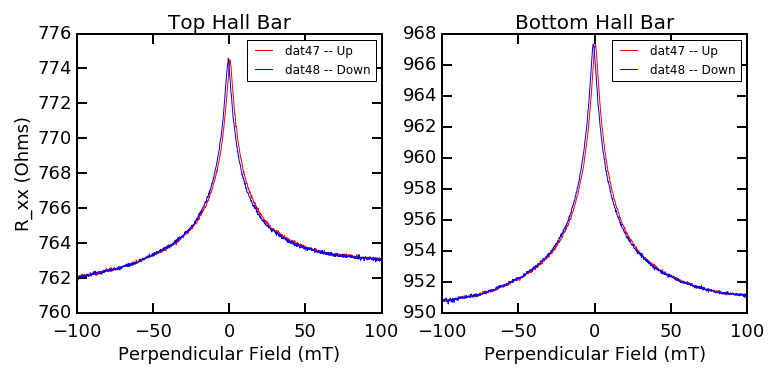

In [793]:
### Large field sweeps at zero parallel field ###

# 47 -- up sweep from -100 to 100mT
# 48 -- down sweep from +100 to -100mT

dat1 = 'dat47' # up sweep
dat2 = 'dat48' # down sweep

fig, ax = plt.subplots(1,2, figsize = (12, 5))

tw1 = Waves(dat1+'g6x.ibw')
tw2 = Waves(dat2+'g6x.ibw')

ax[0].plot(tw1.x, tw1.y, c='r', label = dat1+' -- Up') # up sweep
ax[0].plot(tw2.x, tw2.y, c='b', label = dat2+' -- Down') # down sweep
ax[0].legend()
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

bw1 = Waves(dat1+'g8x.ibw')
bw2 = Waves(dat2+'g8x.ibw')

ax[1].plot(bw1.x, bw1.y, c='r', label = dat1+' -- Up') # up sweep
ax[1].plot(bw2.x, bw2.y, c='b', label = dat2+' -- Down') # down sweep
ax[1].legend()
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')

Small field sweeps at zero parallel field. Note that these sweeps are centered near 0.5mT. This is because of some hysteresis induced after sweeping to high field

(-6, 6)

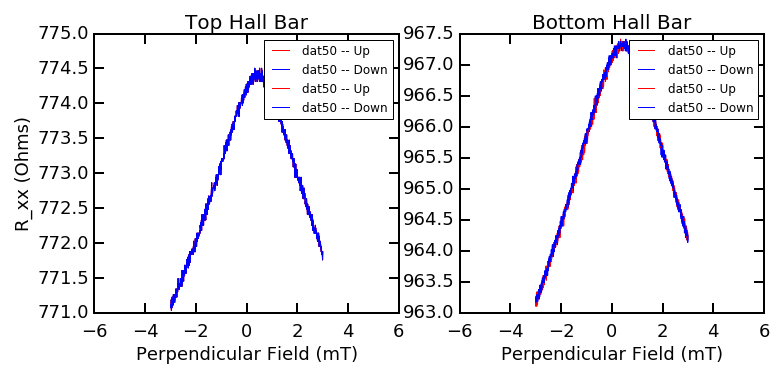

In [32]:
# 50 -- up sweep from -3 to 3mT
# 51 -- down sweep from +3 to -3mT
# 52 -- up sweep from -3 to 3mT
# 53 -- down sweep from +3 to -3mT

dat1 = 'dat50' # up sweep
dat2 = 'dat51' # down sweep
dat3 = 'dat52' # up sweep
dat4 = 'dat53' # down sweep

fig, ax = plt.subplots(1,2, figsize = (12, 5))

tw1 = Waves(dat1+'g6x.ibw')
tw2 = Waves(dat1+'g6x.ibw')
tw3 = Waves(dat1+'g6x.ibw')
tw4 = Waves(dat1+'g6x.ibw')

ax[0].plot(tw1.x, tw1.y, c='r', label = dat1+' -- Up') # up sweep
ax[0].plot(tw2.x, tw2.y, c='b', label = dat1+' -- Down') # down sweep
ax[0].plot(tw3.x, tw3.y, c='r', label = dat1+' -- Up') # up sweep
ax[0].plot(tw4.x, tw4.y, c='b', label = dat1+' -- Down') # down sweep
ax[0].legend()
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

bw1 = Waves(dat1+'g8x.ibw')
bw2 = Waves(dat2+'g8x.ibw')
bw3 = Waves(dat3+'g8x.ibw')
bw4 = Waves(dat4+'g8x.ibw')

ax[1].plot(bw1.x, bw1.y, c='r', label = dat1+' -- Up') # up sweep
ax[1].plot(bw2.x, bw2.y, c='b', label = dat1+' -- Down') # down sweep
ax[1].plot(bw3.x, bw3.y, c='r', label = dat1+' -- Up') # up sweep
ax[1].plot(bw4.x, bw4.y, c='b', label = dat1+' -- Down') # down sweep
ax[1].legend()
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')

ax[0].set_xlim(-6, 6)
ax[1].set_xlim(-6, 6)

Comparing large and small field sweeps at zero parallel field.

Note that these sweeps are centered near 0.5mT. This is because of some hysteresis induced after sweeping to high field

(-6, 6)

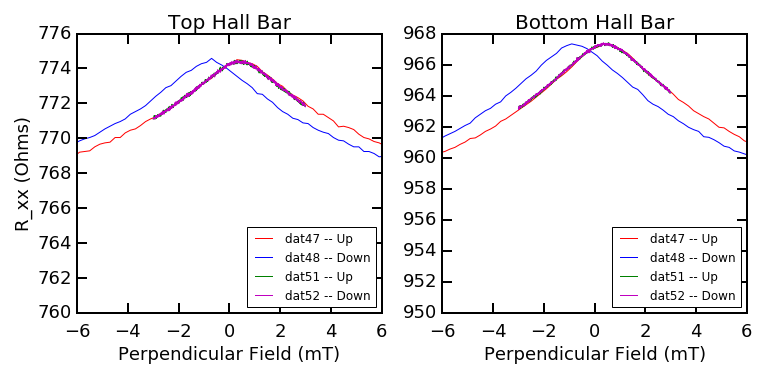

In [33]:
# 47 -- up sweep from -100 to 100mT
# 48 -- down sweep from +100 to -100mT
# 50 -- up sweep from -3 to 3mT
# 51 -- down sweep from +3 to -3mT

dat1 = 'dat47' # up sweep
dat2 = 'dat48' # down sweep
dat3 = 'dat51' # up sweep
dat4 = 'dat52' # down sweep

fig, ax = plt.subplots(1,2, figsize = (12, 5))

tw1 = Waves(dat1+'g6x.ibw')
tw2 = Waves(dat2+'g6x.ibw')
tw3 = Waves(dat3+'g6x.ibw')
tw4 = Waves(dat4+'g6x.ibw')

ax[0].plot(tw1.x, tw1.y, c='r', label = dat1+' -- Up') # up sweep
ax[0].plot(tw2.x, tw2.y, c='b', label = dat2+' -- Down') # down sweep
ax[0].plot(tw3.x, tw3.y, c='g', label = dat3+' -- Up') # up sweep
ax[0].plot(tw4.x, tw4.y, c='m', label = dat4+' -- Down') # down sweep
ax[0].legend(loc='lower right')
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

bw1 = Waves(dat1+'g8x.ibw')
bw2 = Waves(dat2+'g8x.ibw')
bw3 = Waves(dat3+'g8x.ibw')
bw4 = Waves(dat4+'g8x.ibw')

ax[1].plot(bw1.x, bw1.y, c='r', label = dat1+' -- Up') # up sweep
ax[1].plot(bw2.x, bw2.y, c='b', label = dat2+' -- Down') # down sweep\
ax[1].plot(bw3.x, bw3.y, c='g', label = dat3+' -- Up') # up sweep
ax[1].plot(bw4.x, bw4.y, c='m', label = dat4+' -- Down') # down sweep
ax[1].legend(loc='lower right')
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')

ax[0].set_xlim(-6, 6)
ax[1].set_xlim(-6, 6)

Trying to scan the peak centered at it's maximum value.

(-6, 6)

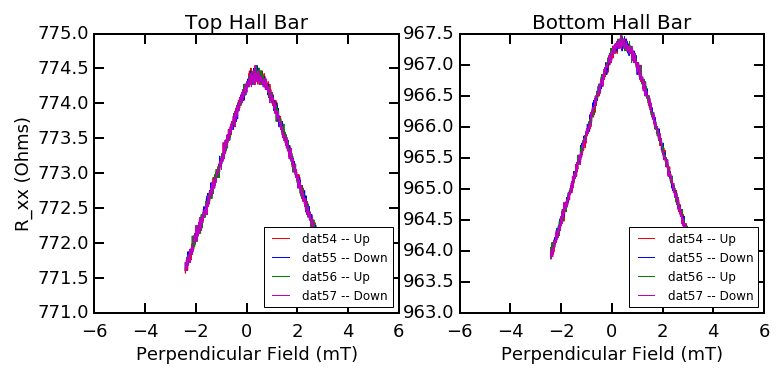

In [34]:
# dat54 -- up sweep from -2.42 to 3.58mT
# dat55 -- down sweep from 3.58 to -2.42mT
# dat56 -- up sweep from -2.42 to 3.58mT
# dat57 -- down sweep from 3.58 to -2.42mT

dat1 = 'dat54' # up sweep
dat2 = 'dat55' # down sweep
dat3 = 'dat56' # up sweep
dat4 = 'dat57' # down sweep

fig, ax = plt.subplots(1,2, figsize = (12, 5))

tw1 = Waves(dat1+'g6x.ibw')
tw2 = Waves(dat2+'g6x.ibw')
tw3 = Waves(dat3+'g6x.ibw')
tw4 = Waves(dat4+'g6x.ibw')

ax[0].plot(tw1.x, tw1.y, c='r', label = dat1+' -- Up') # up sweep
ax[0].plot(tw2.x, tw2.y, c='b', label = dat2+' -- Down') # down sweep
ax[0].plot(tw3.x, tw3.y, c='g', label = dat3+' -- Up') # up sweep
ax[0].plot(tw4.x, tw4.y, c='m', label = dat4+' -- Down') # down sweep
ax[0].legend(loc='lower right')
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

bw1 = Waves(dat1+'g8x.ibw')
bw2 = Waves(dat2+'g8x.ibw')
bw3 = Waves(dat3+'g8x.ibw')
bw4 = Waves(dat4+'g8x.ibw')

ax[1].plot(bw1.x, bw1.y, c='r', label = dat1+' -- Up') # up sweep
ax[1].plot(bw2.x, bw2.y, c='b', label = dat2+' -- Down') # down sweep\
ax[1].plot(bw3.x, bw3.y, c='g', label = dat3+' -- Up') # up sweep
ax[1].plot(bw4.x, bw4.y, c='m', label = dat4+' -- Down') # down sweep
ax[1].legend(loc='lower right')
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')

ax[0].set_xlim(-6, 6)
ax[1].set_xlim(-6, 6)

Plotting all the small field data together

(-6, 6)

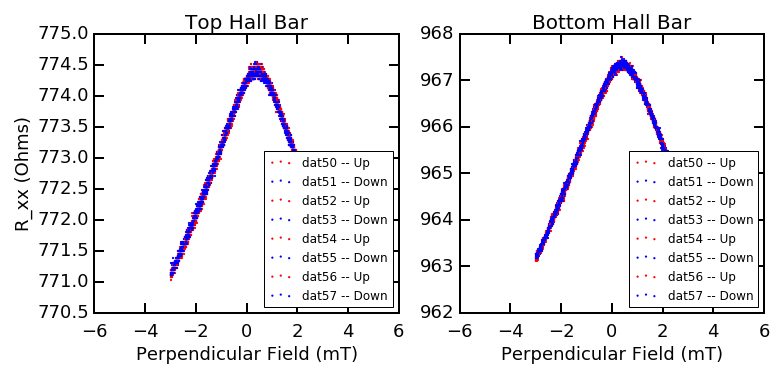

In [35]:
datfiles = [('dat50','Up'), 
            ('dat51','Down'),
            ('dat52','Up'),
            ('dat53','Down'),
            ('dat54','Up'), 
            ('dat55','Down'),
            ('dat56','Up'),
            ('dat57','Down')]

fig, ax = plt.subplots(1,2, figsize = (12, 5))

for k, v in datfiles:
    
    tw = Waves(k+'g6x.ibw')
    bw = Waves(k+'g8x.ibw')

    if v == 'Up':
        ax[0].scatter(tw.x, tw.y, c='r', s = 5, lw=0, label = k+' -- '+v) # up sweep
        ax[1].scatter(bw.x, bw.y, c='r', s = 5, lw=0, label = k+' -- '+v) # up sweep
    elif v == 'Down':
        ax[0].scatter(tw.x, tw.y, c='b', s = 5, lw=0, label = k+' -- '+v) # down sweep
        ax[1].scatter(bw.x, bw.y, c='b', s = 5, lw=0, label = k+' -- '+v) # down sweep

ax[0].legend(loc='lower right')
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

ax[1].legend(loc='lower right')
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')

ax[0].set_xlim(-6, 6)
ax[1].set_xlim(-6, 6)

Sweep field to +/- 10mT to look for any hysteresis in that range.

(-3, 3)

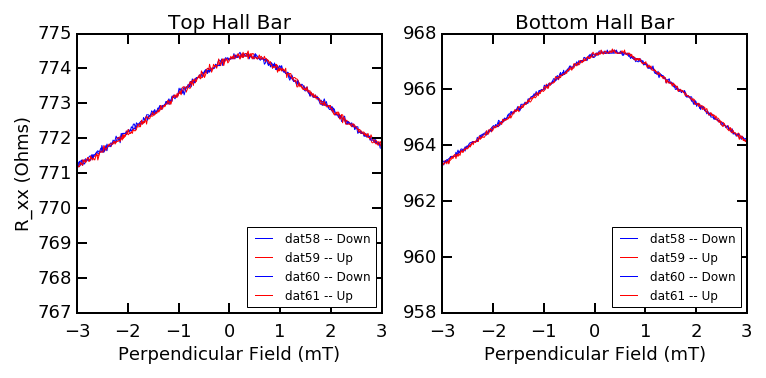

In [39]:
# dat58 -- down sweep from 10 to -10mT
# dat59 -- up sweep from -10 to 10mT
# dat60 -- down sweep from 10 to -10mT
# dat61 -- up sweep from -10 to 10mT
# dat62 -- down sweep from 10 to 0mT (not plotted)

datfiles = [('dat58','Down'), 
            ('dat59','Up'),
            ('dat60','Down'),
            ('dat61','Up')]

fig, ax = plt.subplots(1,2, figsize = (12, 5))

for k, v in datfiles:
    
    tw = Waves(k+'g6x.ibw')
    bw = Waves(k+'g8x.ibw')

    if v == 'Up':
        ax[0].plot(tw.x, tw.y, c='r', lw=1, label = k+' -- '+v) # up sweep
        ax[1].plot(bw.x, bw.y, c='r', lw=1, label = k+' -- '+v) # up sweep
    elif v == 'Down':
        ax[0].plot(tw.x, tw.y, c='b', lw=1, label = k+' -- '+v) # down sweep
        ax[1].plot(bw.x, bw.y, c='b', lw=1, label = k+' -- '+v) # down sweep

ax[0].legend(loc='lower right')
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

ax[1].legend(loc='lower right')
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')

ax[0].set_xlim(-3, 3)
ax[1].set_xlim(-3, 3)

After the +/-10mT sweep, check that the +/-3mT data does not change

(-6, 6)

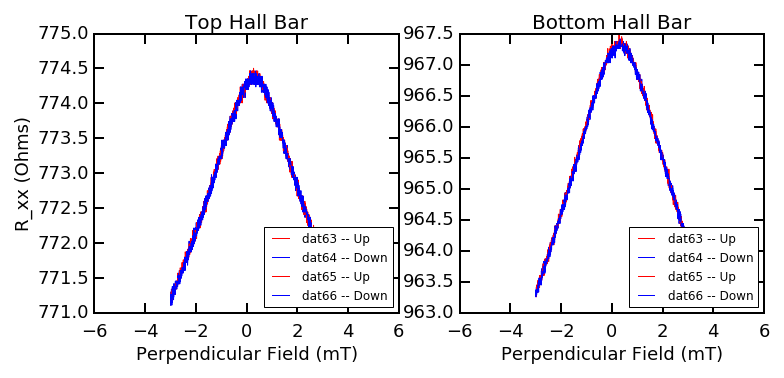

In [40]:
# dat63 -- up sweep from -3 to 3mT
# dat64 -- down sweep from 3 to -3mT
# dat65 -- up sweep from -3 to 3mT
# dat66 -- down sweep from 3 to -3mT
# dat67 -- up sweep from -3 to 0mT (not plotted)


datfiles = [('dat63','Up'),
            ('dat64','Down'),
            ('dat65','Up'),
            ('dat66','Down')]

fig, ax = plt.subplots(1,2, figsize = (12, 5))

for k, v in datfiles:
    
    tw = Waves(k+'g6x.ibw')
    bw = Waves(k+'g8x.ibw')

    if v == 'Up':
        ax[0].plot(tw.x, tw.y, c='r', lw=1, label = k+' -- '+v) # up sweep
        ax[1].plot(bw.x, bw.y, c='r', lw=1, label = k+' -- '+v) # up sweep
    elif v == 'Down':
        ax[0].plot(tw.x, tw.y, c='b', lw=1, label = k+' -- '+v) # down sweep
        ax[1].plot(bw.x, bw.y, c='b', lw=1, label = k+' -- '+v) # down sweep

ax[0].legend(loc='lower right')
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

ax[1].legend(loc='lower right')
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')

ax[0].set_xlim(-6, 6)
ax[1].set_xlim(-6, 6)

Check all of the +/-3mT data together

(-4, 8)

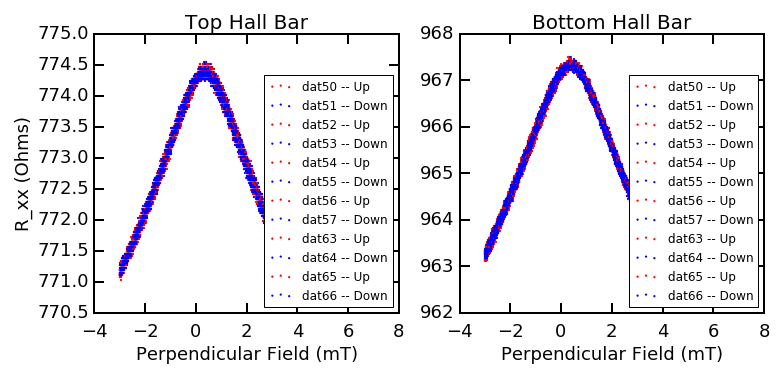

In [41]:
datfiles = [('dat50','Up'), 
            ('dat51','Down'),
            ('dat52','Up'),
            ('dat53','Down'),
            ('dat54','Up'), 
            ('dat55','Down'),
            ('dat56','Up'),
            ('dat57','Down'),
            ('dat63','Up'),
            ('dat64','Down'),
            ('dat65','Up'),
            ('dat66','Down')]

fig, ax = plt.subplots(1,2, figsize = (12, 5))

for k, v in datfiles:
    
    tw = Waves(k+'g6x.ibw')
    bw = Waves(k+'g8x.ibw')

    if v == 'Up':
        ax[0].scatter(tw.x, tw.y, c='r', s = 5, lw=0, label = k+' -- '+v) # up sweep
        ax[1].scatter(bw.x, bw.y, c='r', s = 5, lw=0, label = k+' -- '+v) # up sweep
    elif v == 'Down':
        ax[0].scatter(tw.x, tw.y, c='b', s = 5, lw=0, label = k+' -- '+v) # down sweep
        ax[1].scatter(bw.x, bw.y, c='b', s = 5, lw=0, label = k+' -- '+v) # down sweep

ax[0].legend(loc='lower right')
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

ax[1].legend(loc='lower right')
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')

ax[0].set_xlim(-4, 8)
ax[1].set_xlim(-4, 8)

Large field sweep to test if I can switch peaks by sweeping the large field.

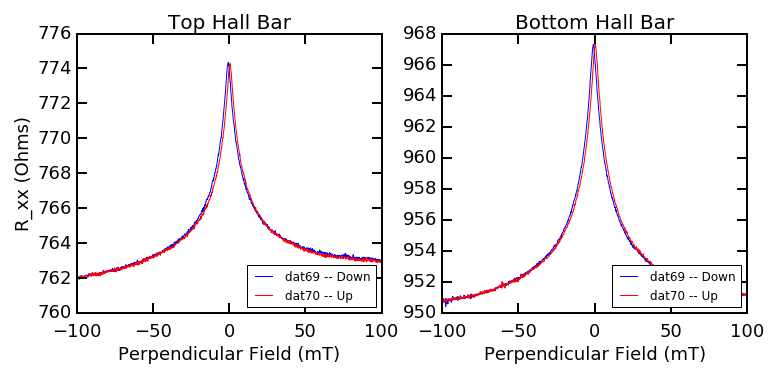

In [44]:
# dat68 -- up sweep from 0 to 100mT (not plotted)
# dat69 -- down sweep from 100 to -100 mT
# dat70 -- up sweep from -100 to 100 mT
# dat71 -- down sweep from 100 to 0 mT (not plotted)

datfiles = [('dat69','Down'),
            ('dat70','Up')]

fig, ax = plt.subplots(1,2, figsize = (12, 5))

for k, v in datfiles:
    
    tw = Waves(k+'g6x.ibw')
    bw = Waves(k+'g8x.ibw')

    if v == 'Up':
        ax[0].plot(tw.x, tw.y, c='r', lw=1, label = k+' -- '+v) # up sweep
        ax[1].plot(bw.x, bw.y, c='r', lw=1, label = k+' -- '+v) # up sweep
    elif v == 'Down':
        ax[0].plot(tw.x, tw.y, c='b', lw=1, label = k+' -- '+v) # down sweep
        ax[1].plot(bw.x, bw.y, c='b', lw=1, label = k+' -- '+v) # down sweep

ax[0].legend(loc='lower right')
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

ax[1].legend(loc='lower right')
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')

# ax[0].set_xlim(-6, 6)
# ax[1].set_xlim(-6, 6)

Check that the +/- 3mT data is now following the other peak.

(-6, 6)

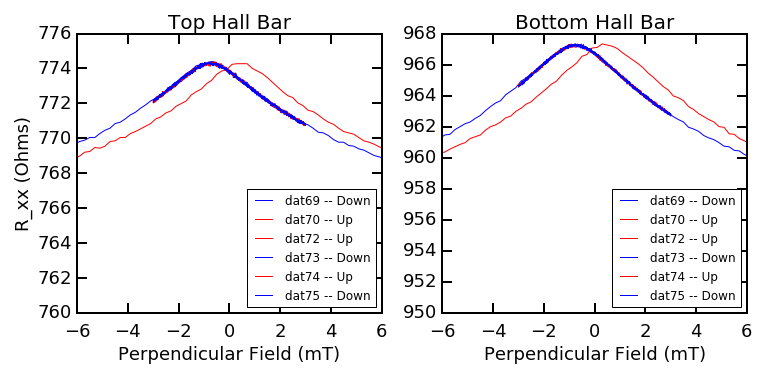

In [45]:
# dat72 -- up sweep from -3 to 3 mT
# dat73 -- down sweep from 3 to -3 mT
# dat74 -- up sweep from -3 to 3 mT
# dat75 -- down sweep from 3 to -3 mT
# dat76 -- up sweep from -3 to 0 mT (not plotted)

datfiles = [('dat69','Down'),
            ('dat70','Up'),
            ('dat72', 'Up'),
            ('dat73','Down'),
            ('dat74','Up'), 
            ('dat75', 'Down')]

fig, ax = plt.subplots(1,2, figsize = (12, 5))

for k, v in datfiles:
    
    tw = Waves(k+'g6x.ibw')
    bw = Waves(k+'g8x.ibw')

    if v == 'Up':
        ax[0].plot(tw.x, tw.y, c='r', lw=1, label = k+' -- '+v) # up sweep
        ax[1].plot(bw.x, bw.y, c='r', lw=1, label = k+' -- '+v) # up sweep
    elif v == 'Down':
        ax[0].plot(tw.x, tw.y, c='b', lw=1, label = k+' -- '+v) # down sweep
        ax[1].plot(bw.x, bw.y, c='b', lw=1, label = k+' -- '+v) # down sweep

ax[0].legend(loc='lower right')
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

ax[1].legend(loc='lower right')
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')

ax[0].set_xlim(-6, 6)
ax[1].set_xlim(-6, 6)

Look at all +/- 3mT datasets.

(-4, 8)

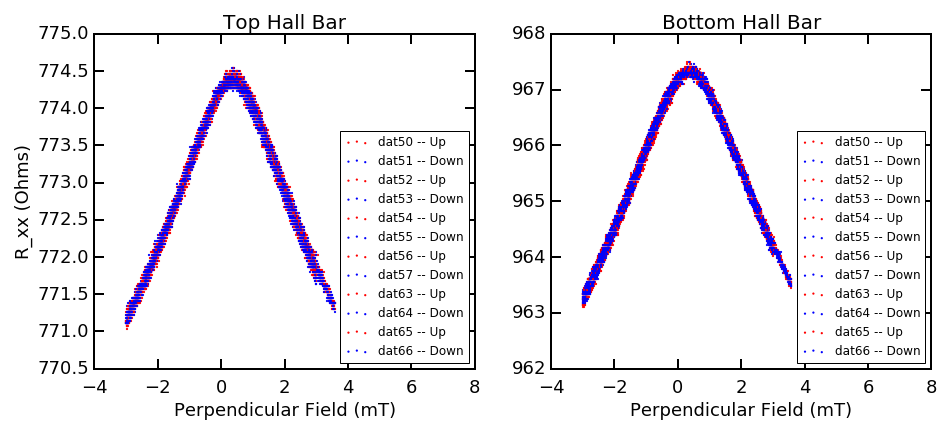

In [46]:
datfiles = [('dat50','Up'), 
            ('dat51','Down'),
            ('dat52','Up'),
            ('dat53','Down'),
            ('dat54','Up'), 
            ('dat55','Down'),
            ('dat56','Up'),
            ('dat57','Down'),
            ('dat63','Up'),
            ('dat64','Down'),
            ('dat65','Up'),
            ('dat66','Down')]

top_field = np.zeros(1000)
top_r = np.zeros(1000)
bottom_field = np.zeros(1000)
bottom_r = np.zeros(1000)

fig, ax = plt.subplots(1,2, figsize = (15, 6))

for k, v in datfiles:
    
    tw = Waves(k+'g6x.ibw')
    bw = Waves(k+'g8x.ibw')

    if v == 'Up':
        ax[0].scatter(tw.x, tw.y, c='r', s = 5, lw=0, label = k+' -- '+v) # up sweep
        ax[1].scatter(bw.x, bw.y, c='r', s = 5, lw=0, label = k+' -- '+v) # up sweep
    elif v == 'Down':
        ax[0].scatter(tw.x, tw.y, c='b', s = 5, lw=0, label = k+' -- '+v) # down sweep
        ax[1].scatter(bw.x, bw.y, c='b', s = 5, lw=0, label = k+' -- '+v) # down sweep

ax[0].legend(loc='lower right')
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

ax[1].legend(loc='lower right')
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')

ax[0].set_xlim(-4, 8)
ax[1].set_xlim(-4, 8)

Plot perpendicular field data taken as a function of parallel field data at 6K

Here is some text

Here is some $\LaTeX$.

NameError: name 'wave' is not defined

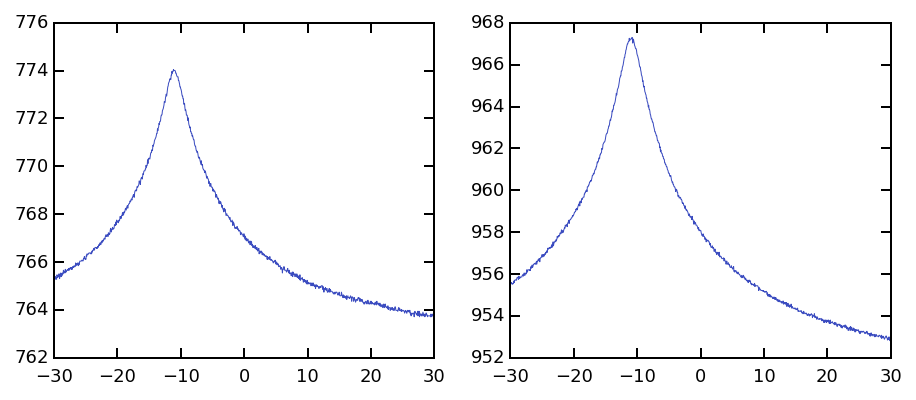

In [191]:
# Note: this file naming scheme was immediately abandoned due to it's unpopularity in the lab

datfile = 'additional_data/dat87'
fields = ['-400', '-300', '-200', '-100', '0', '100', '200', '300', '400']
palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(fields))))

fig, ax = plt.subplots(1,2, figsize = (15, 6))

for field in fields:
    # up sweeps
    tw = Waves('{0}g6x_{1}_up.ibw'.format(datfile, field))
    bw = Waves('{0}g8x_{1}_up.ibw'.format(datfile, field))
    
    color = color=next(palette)
    ax[0].plot(tw.x, tw.y, color=color, label = '{0} mT'.format(field))
    ax[1].plot(bw.x, bw.y, color=color, label = '{0} mT'.format(field))
    
    #down sweeps
    tw = wave.load('{0}g6x_{1}_down.ibw'.format(datfile, field))
    bw = wave.load('{0}g8x_{1}_down.ibw'.format(datfile, field))
    
    ax[0].plot(tw.x, tw.y, color=color)
    ax[1].plot(bw.x, bw.y, color=color)
    
# ax[0].legend(loc='lower right')
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xx (Ohms)')

# ax[1].legend(loc='lower right')
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')
ax[1].legend()

IOError: [Errno 2] No such file or directory: 'dat87g5x_-400_up.ibw'

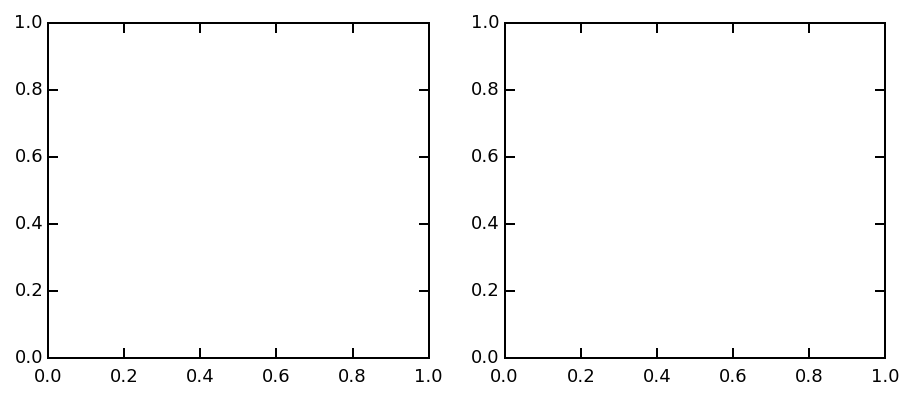

In [54]:
### same data set as above, R_xy ###

datfile = 'dat87'
fields = ['-400', '-300', '-200', '-100', '0', '100', '200', '300', '400']
palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(fields))))

fig, ax = plt.subplots(1,2, figsize = (15, 6))

for field in fields:
    # up sweeps
    tw = Waves('{0}g5x_{1}_up.ibw'.format(datfile, field))
    bw = Waves('{0}g9x_{1}_up.ibw'.format(datfile, field))
    
    color = color=next(palette)
    ax[0].plot(tw.x, tw.y, color=color, label = '{0} mT'.format(field))
    ax[1].plot(bw.x, bw.y, color=color, label = '{0} mT'.format(field))
    
    #down sweeps
    tw = wave.load('{0}g5x_{1}_down.ibw'.format(datfile, field))
    bw = wave.load('{0}g9x_{1}_down.ibw'.format(datfile, field))
    
    ax[0].plot(tw.x, tw.y, color=color)
    ax[1].plot(bw.x, bw.y, color=color)
    
# ax[0].legend(loc='lower right')
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xy (Ohms)')

# ax[1].legend(loc='lower right')
ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')
ax[1].legend(loc='lower right')

## 2K data

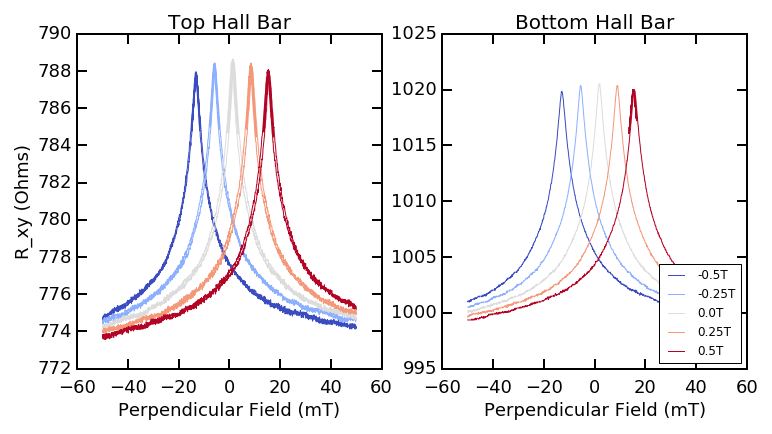

In [61]:
filelist = ['dat{0}'.format(n) for n in range(120, 150)]
fields = np.array([-0.5, -0.25, 0.0, 0.25, 0.5])

palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(fields)))) # set color palette
sweeps = len(filelist)/len(fields) # number of sweeps per field value
fields = np.repeat(fields, sweeps) # create array of fields corresponding to dat filelist

VtoR_top = (1.0/99.88e-9)*(1.0/1000.0)
VtoR_bottom = (1.0/99.88e-9)*(1.0/1000.0)

fig, ax = plt.subplots(1,2, figsize = (12, 6))

for i, f in enumerate(filelist):

    tw = Waves(f+'g6x.ibw')
    bw = Waves(f+'g8x.ibw')
    
    if i%sweeps == 0:
        color = color=next(palette)
        ax[1].plot(bw.x, bw.y*VtoR_bottom, color=color, label = '{0}T'.format(fields[i]))
    else:
        ax[1].plot(bwx, bwy*VtoR_bottom, color=color)
    ax[0].plot(tw.x, tw.y*VtoR_top, color=color)
    
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xy (Ohms)')

ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')
ax[1].legend(loc='lower right')

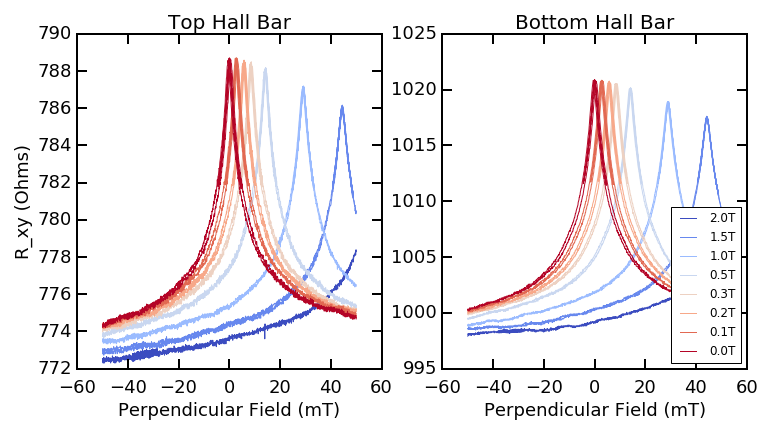

In [63]:
filelist = ['dat{0}'.format(n) for n in range(157, 205)] # generate dat filelist

fields = np.array([2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.0]) # field values used
palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(fields)))) # set color palette
sweeps = len(filelist)/len(fields) # number of sweeps per field value
fields = np.repeat(fields, sweeps) # create array of fields corresponding to dat filelist

VtoR_top = (1.0/99.88e-9)*(1.0/1000.0)
VtoR_bottom = (1.0/99.88e-9)*(1.0/1000.0)

fig, ax = plt.subplots(1,2, figsize = (12, 6))

for i, f in enumerate(filelist):

    tw = Waves(f+'g6x.ibw')
    bw = Waves(f+'g8x.ibw')

    if i%sweeps == 0:
        color =next(palette)
        ax[1].plot(bw.x, bw.y*VtoR_bottom, color=color, label = '{0}T'.format(fields[i]))
    else:
        ax[1].plot(bw.x, bw.y*VtoR_bottom, color=color)
    ax[0].plot(tw.x, tw.y*VtoR_top, color=color)
    
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xy (Ohms)')
# ax[0].set_xlim(25,35)

ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')
ax[1].legend(loc='lower right')
# ax[1].set_xlim(25,35)

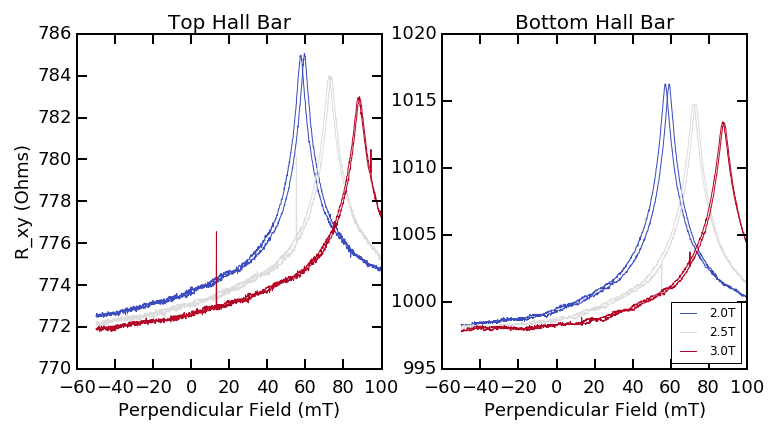

In [82]:
filelist = ['dat{0}'.format(n) for n in range(205, 211)] # generate dat filelist

fields = np.array([2.0, 2.5, 3.0]) # field values used
palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(fields)))) # set color palette
sweeps = len(filelist)/len(fields) # number of sweeps per field value
fields = np.repeat(fields, sweeps) # create array of fields corresponding to dat filelist

VtoR_top = (1.0/99.88e-9)*(1.0/1000.0)
VtoR_bottom = (1.0/99.88e-9)*(1.0/1000.0)

fig, ax = plt.subplots(1,2, figsize = (12, 6))

for i, f in enumerate(filelist):

    tw = Waves(f+'g6x.ibw')
    bw = Waves(f+'g8x.ibw')
    
    if i%sweeps == 0:
        color = color=next(palette)
        ax[1].plot(bw.x, bw.y*VtoR_bottom, color=color, label = '{0}T'.format(fields[i]))
    else:
        ax[1].plot(bw.x, bw.y*VtoR_bottom, color=color)
    ax[0].plot(tw.x, tw.y*VtoR_top, color=color)
    
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xy (Ohms)')
# ax[0].set_xlim(25,35)

ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')
ax[1].legend(loc='lower right')
# ax[1].set_xlim(25,35)

NameError: name 'wave' is not defined

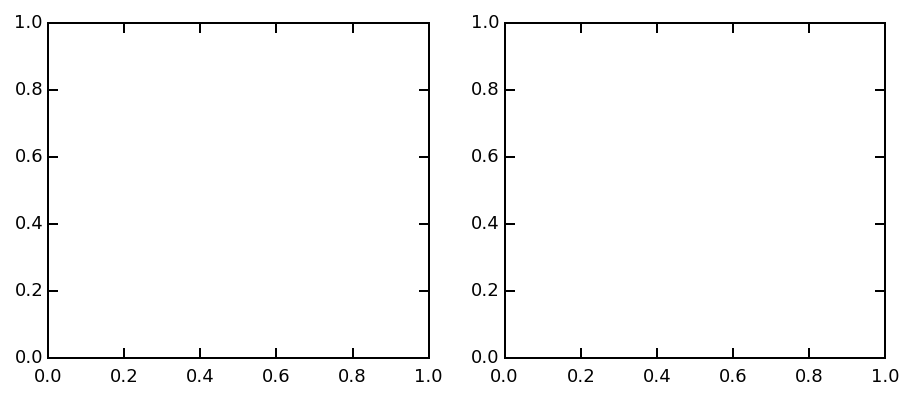

In [66]:
filelist = ['dat211', 'dat221', 'dat223', 'dat225']
fields = np.array([0.0])

palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(fields)))) # set color palette
sweeps = len(filelist)/len(fields) # number of sweeps per field value
fields = np.repeat(fields, sweeps) # create array of fields corresponding to dat filelist

VtoR_top = (1.0/99.88e-9)*(1.0/1000.0)
VtoR_bottom = (1.0/99.88e-9)*(1.0/1000.0)

fig, ax = plt.subplots(1,2, figsize = (15, 6))

tdf = pd.DataFrame()
bdf = pd.DataFrame()

for i, f in enumerate(filelist):

    tw = Waves(f+'g6x.ibw')
    bw = Waves(f+'g8x.ibw')

    a = wave.as_dataframe(tw)
    a.y*=VtoRho_top
    ax[0].scatter(a.x, a.y, c='b', lw=0)
    tdf = tdf.append(a)
    
    b = wave.as_dataframe(bw)
    b.y*=VtoRho_top
    ax[1].scatter(b.x, b.y, c='b', lw=0)
    bdf = bdf.append(b)
    
tdf = tdf.groupby('x', as_index=False).mean()
tdf = pd.rolling_mean(tdf, 2)

bdf = bdf.groupby('x', as_index=False).mean()
bdf = pd.rolling_mean(bdf, 2)
    
ax[0].plot(tdf.x, tdf.y, 'r')
ax[1].plot(bdf.x, bdf.y, 'r')
    
ax[0].set_title('Top Hall Bar')
ax[0].set_xlabel('Perpendicular Field (mT)')
ax[0].set_ylabel('R_xy (Ohms)')
# ax[0].set_xlim(-100,-50)
# ax[0].set_ylim(512, 518)

ax[1].set_title('Bottom Hall Bar')
ax[1].set_xlabel('Perpendicular Field (mT)')
ax[1].legend(loc='lower right')
# ax[1].set_xlim(-100,-50)
# ax[1].set_ylim(664, 668)

Some notes from talking to Silvia about fitting:

-get data sets for one peak  
-mean plot -- put in units of ohms/sq and average over data sets  
-fit to WL function over large field  
-use that data to fix B_i, B_start and fit to find B_phi over small field  
-go back to large field sweep, fix B_phi, fit again to find more accurate values of B_i, B_star  
-repeat, if necessary, to get all of these values to converge  

First thing to do is define the actual fitting function. Here is the definition from the Igor code:

    function wlcorr(b,bo,ro,B_phi,B_i,B_star,lin,A)
        variable b,B_phi,B_i,B_star,bo,ro,lin,A
        variable e=1.60217646e-19,  mstar=8.724125937209915e-32,h=6.626068e-34 , Go=7.45e-5, hbar=h/2/pi
        //variable D=5.106250385935459e-03
        variable z1, F1, z2, F2, z3, F3

        b=b+bo

        z1=abs(b)/B_phi;
        F1=ln(z1)+digamma(0.5+1/z1);

        z2=abs(b)/(B_phi+2*B_i);
        F2=ln(z2)+digamma(0.5+1/z2);

        z3=abs(b)/(B_phi+B_star);
        F3=ln(z3)+digamma(0.5+1/z3);

        return lin*b+ro-ro^2*(e*e/pi/h*(F1-F2-2*F3))*A;

    end

#### Fits of 2K data to find parameters A, B_i, B_star, lin...

## Base Temperature data

Below is analysis of the base temperature data with gaussian spacing.

(-50, 120)

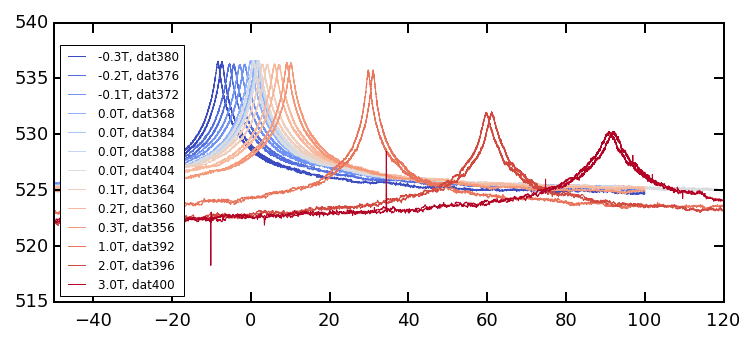

In [88]:
dat_files = [('dat380', -0.3, 'Up', 50),
             ('dat381', -0.3, 'Down', 50),
             ('dat376', -0.2, 'Up', 50),
             ('dat377', -0.2, 'Down', 50),
             ('dat372', -0.1, 'Up', 50),
             ('dat373', -0.1, 'Down', 50),
             ('dat335', 0.0, 'Up', 100), 
             ('dat336', 0.0, 'Down', 100),
             ('dat368', 0.0, 'Up', 50),
             ('dat369', 0.0, 'Down', 50),
             ('dat384', 0.0, 'Up', 50),
             ('dat385', 0.0, 'Down', 50),
             ('dat388', 0.0, 'Up', 50),
             ('dat389', 0.0, 'Down', 50),
             ('dat404', 0.0, 'Up', 50),
             ('dat405', 0.0, 'Down', 50),
             ('dat364', 0.1, 'Up', 50),
             ('dat365', 0.1, 'Down', 50),
             ('dat360', 0.2, 'Up', 50),
             ('dat361', 0.2, 'Down', 50),
             ('dat356', 0.3, 'Up', 50),
             ('dat357', 0.3, 'Down', 50),
             ('dat351', 0.4, 'Up', 100),
             ('dat352', 0.4, 'Down', 100),
             ('dat339', 0.5, 'Up', 100), 
             ('dat340', 0.5, 'Down', 100), 
             ('dat343', 1.0, 'Up', 100), 
             ('dat344', 1.0, 'Down', 100), 
             ('dat347', 1.0, 'Up', 100), 
             ('dat348', 1.0, 'Down', 100), 
             ('dat392', 1.0, 'Up', 50),
             ('dat393', 1.0, 'Down', 50), 
             ('dat396', 2.0, 'Up', 50),
             ('dat397', 2.0, 'Down', 50), 
             ('dat400', 3.0, 'Up', 50),
             ('dat401', 3.0, 'Down', 50)]


dat_df = pd.DataFrame(dat_files, columns = ['Dat', 'Parallel', 'Dir', 'Bias'])
dat_df = dat_df[dat_df['Bias'] == 50.0]
scale = 1.0/1000.0/1.5
palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(dat_df)/2)))

fig, ax = plt.subplots(1,1, figsize = (12,5))

for t in dat_df.iterrows():
    row = t[1]
    f = row['Dat']

    if row['Bias'] == 50:
        rxx = Waves(f+'g6x.ibw')
        rxx.scale_y(scale/50.00e-9)
        rxy = Waves(f+'g5x.ibw')
        rxy.scale_y(scale/50.00e-9)
    elif row['Bias'] == 100:
        rxx = Waves(f+'g6x.ibw')
        rxx.scale_y(scale/99.88e-9)
        rxy = Waves(f+'g5x.ibw')
        rxy.scale_y(scale/99.88e-9)
    fields = Waves(f+'fields.ibw')
    fields.scale_y(4.01*11.67)
    if row['Dir'] == 'Up':
        color = next(palette)
        ax.plot(fields.y, rxx.y, color=color, label='{0:.1f}T, {1}'.format(row['Parallel'], row['Dat']))
    else:
        ax.plot(fields.y, rxx.y, color=color)
#         ax.plot(rxy.y, rxx.y)

ax.legend(loc='lower left')
ax.set_xlim(-50, 120)

Some strange behavior here around zero parallel field. Plot all zero parallel field data to check

(-20, 20)

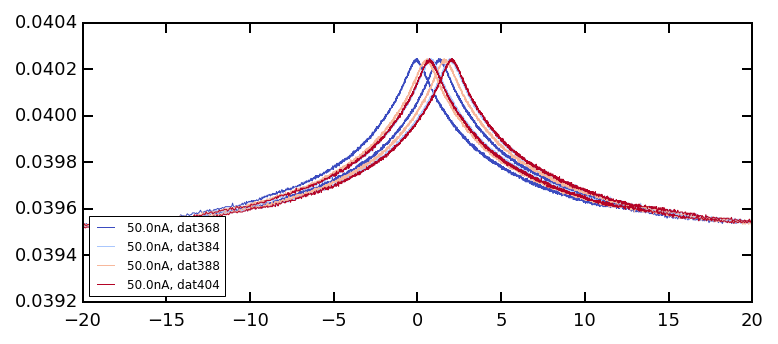

In [89]:
zero_df = dat_df[dat_df['Parallel']==0.0]
scale = 1.0/1000.0/1.5
palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(zero_df)/2)))

fig, ax = plt.subplots(1,1, figsize = (12, 5))

for t in zero_df.iterrows():
    row = t[1]
    f = row['Dat']

    if row['Bias'] == 50:
        rxx = Waves(f+'g6x.ibw')
        #rxx.scale_y(scale/50.00e-9)
        rxy = Waves(f+'g5x.ibw')
        #rxy.scale_y(scale/50.00e-9)
    elif row['Bias'] == 100:
        rxx = Waves(f+'g6x.ibw')
        #rxx.scale_y(scale/99.88e-9)
        rxy = Waves(f+'g5x.ibw')
        #rxy.scale_y(scale/99.88e-9)
    fields = Waves(f+'fields.ibw')
    fields.scale_y(4.01*11.67)
    if row['Dir'] == 'Up':
        color = next(palette)
        ax.plot(fields.y, rxx.y, color=color, label='{0:.1f}nA, {1}'.format(row['Bias'], row['Dat']))
    else:
        ax.plot(fields.y, rxx.y, color=color)
#         ax.plot(rxy.y, rxx.y)

ax.legend(loc='lower left')
ax.set_xlim(-20, 20)

The bias in the all of the data until now was *way* too high. Check dependance of curve shapes on bias current.

(-5, 8)

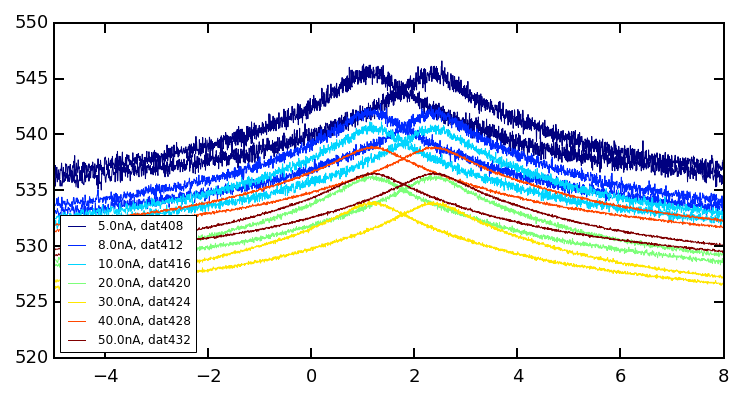

In [91]:
dat_files = [('dat408', 0.0, 'Up', 5),
             ('dat409', 0.0, 'Down', 5),
             ('dat412', 0.0, 'Up', 8),
             ('dat413', 0.0, 'Down', 8),
             ('dat416', 0.0, 'Up', 10),
             ('dat417', 0.0, 'Down', 10),
             ('dat420', 0.0, 'Up', 20), 
             ('dat421', 0.0, 'Down', 20),
             ('dat424', 0.0, 'Up', 30),
             ('dat425', 0.0, 'Down', 30),
             ('dat428', 0.0, 'Up', 40),
             ('dat429', 0.0, 'Down', 40),
             ('dat432', 0.0, 'Up', 50),
             ('dat433', 0.0, 'Down', 50)]


dat_df = pd.DataFrame(dat_files, columns = ['Dat', 'Parallel', 'Dir', 'Bias'])
scale = 1.0/1000.0/1.5
palette = itertools.cycle(plt.cm.jet(np.linspace(0, 1, len(dat_files)/2)))

fig, ax = plt.subplots(1,1, figsize = (12,6))

for t in dat_df.iterrows():
    row = t[1]
    f = row['Dat']

    rxx = Waves(f+'g6x.ibw')
    rxx.scale_y(scale/(row['Bias']*1e-9))
    rxy = Waves(f+'g5x.ibw')
    rxy.scale_y(scale/(row['Bias']*1e-9))

    fields = Waves(f+'fields.ibw')
    if row['Dir'] == 'Up':
        color = next(palette)
        ax.plot(fields.y, rxx.y, color=color, label='{0:.1f}nA, {1}'.format(row['Bias'], row['Dat']))
    else:
        ax.plot(fields.y, rxx.y, color=color)

ax.legend(loc='lower left')
ax.set_xlim(-5,8)

What you're seeing above is basically the sample cooling down as the bias current is lowered. Additional data taken at 10nA is below. I later learned that 10nA bias corresponds to a temperature of roughly 150mK.

(-20, 50)

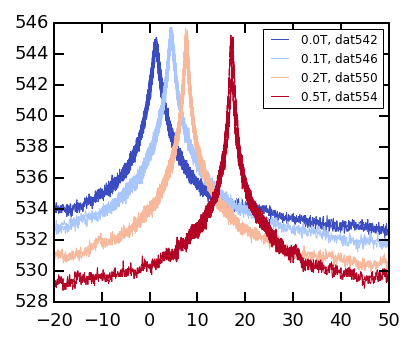

In [94]:
# dat_files = [('dat538', -0.1, 'Up', 10),
#              ('dat539', -0.1, 'Down', 10),
#              ('dat542', 0.0, 'Up', 10),
#              ('dat543', 0.0, 'Down', 10),
#              ('dat546', 0.1, 'Up', 10),
#              ('dat547', 0.1, 'Down', 10),
#              ('dat550', 0.2, 'Up', 10), 
#              ('dat551', 0.2, 'Down', 10),
#              ('dat554', 0.5, 'Up', 10),
#              ('dat555', 0.5, 'Down', 10)]
#              ('dat558', 1.0, 'Up', 10),
#              ('dat559', 1.0, 'Down', 10)]

dat_files = [('dat542', 0.0, 'Up', 10),
             ('dat543', 0.0, 'Down', 10),
             ('dat546', 0.1, 'Up', 10),
             ('dat547', 0.1, 'Down', 10),
             ('dat550', 0.2, 'Up', 10), 
             ('dat551', 0.2, 'Down', 10),
             ('dat554', 0.5, 'Up', 10),
             ('dat555', 0.5, 'Down', 10)]

dat_df = pd.DataFrame(dat_files, columns = ['Dat', 'Parallel', 'Dir', 'Bias'])
scale = 1.0/1000.0/1.5
palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(dat_files)/2)))

fig, ax = plt.subplots(1,1)

for t in dat_df.iterrows():
    row = t[1]
    f = row['Dat']

    rxx = Waves(f+'g6x.ibw')
    rxx.scale_y(scale/(row['Bias']*1e-9))
    rxy = Waves(f+'g5x.ibw')
    rxy.scale_y(scale/(row['Bias']*1e-9))

    fields = Waves(f+'fields.ibw')
    if row['Dir'] == 'Up':
        color = next(palette)
        ax.plot(fields.y, rxx.y, color=color, label='{0:.1f}T, {1}'.format(row['Parallel'], row['Dat']))
    else:
        ax.plot(fields.y, rxx.y, color=color)

ax.legend(loc='upper right')
ax.set_xlim(-20,50)

Lowering further to 4nA. Based on future calibration, the sample temperature here is approximately 55mK. This data is taken as a function of parallel field

(-10, 10)

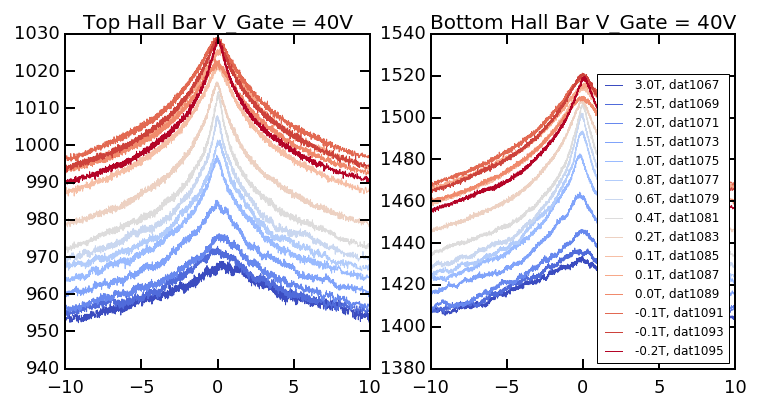

In [99]:
# {3.0, 2.5, 2.0, 1.5, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.005, -0.05, -0.1, -0.2}
dat_files = [('dat1067', 3.0, 'Up', 4.0),
             ('dat1069', 2.5, 'Up', 4.0),
             ('dat1071', 2.0, 'Up', 4.0),
             ('dat1073', 1.5, 'Up', 4.0),
             ('dat1075', 1.0, 'Up', 4.0),
             ('dat1077', 0.8, 'Up', 4.0),
             ('dat1079', 0.6, 'Up', 4.0),
             ('dat1081', 0.4, 'Up', 4.0),
             ('dat1083', 0.2, 'Up', 4.0),
             ('dat1085', 0.1, 'Up', 4.0),
             ('dat1087', 0.05, 'Up', 4.0),
             ('dat1089', 0.005, 'Up', 4.0),
             ('dat1091', -0.05, 'Up', 4.0),
             ('dat1093', -0.1, 'Up', 4.0),
             ('dat1095', -0.2, 'Up', 4.0)]


fig, ax = plt.subplots(1,2, figsize = (12,6), sharex = True)

df = create_wlcorr_dataframe(dat_files)
palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(df))))
for i in range(len(df)):
    row = df.iloc[i,:]

    g6 = Waves(row['dat']+'g6x.ibw') # thb rxx
    g5 = Waves(row['dat']+'g5x.ibw') # thb rxx
    g8 = Waves(row['dat']+'g8x.ibw') # bhb rxx
    g9 = Waves(row['dat']+'g9x.ibw') # bhb rxx
    fields = Waves(row['dat']+'fields.ibw') # perpendicular field values for all
    
    g6.scale_y(scale/(row['bias']*1e-9))
    g5.scale_y(scale/(row['bias']*1e-9))
    g8.scale_y(scale/(row['bias']*1e-9))
    g9.scale_y(scale/(row['bias']*1e-9))
    
    center = fields.y[g6.y.argmax()]

    color = next(palette)
    ax[0].plot(fields.y-center, (g6.y+g5.y)/2.0+i*2, color=color, 
               label='{0:.1f}T, {1}'.format(row['parallel'], row['dat']))
    ax[1].plot(fields.y-center, g8.y+i*2, color=color, 
               label='{0:.1f}T, {1}'.format(row['parallel'], row['dat']))

ax[0].set_title('Top Hall Bar V_Gate = 40V')
ax[1].set_title('Bottom Hall Bar V_Gate = 40V')
ax[1].legend(loc='lower right')
ax[1].set_xlim(-10,10)

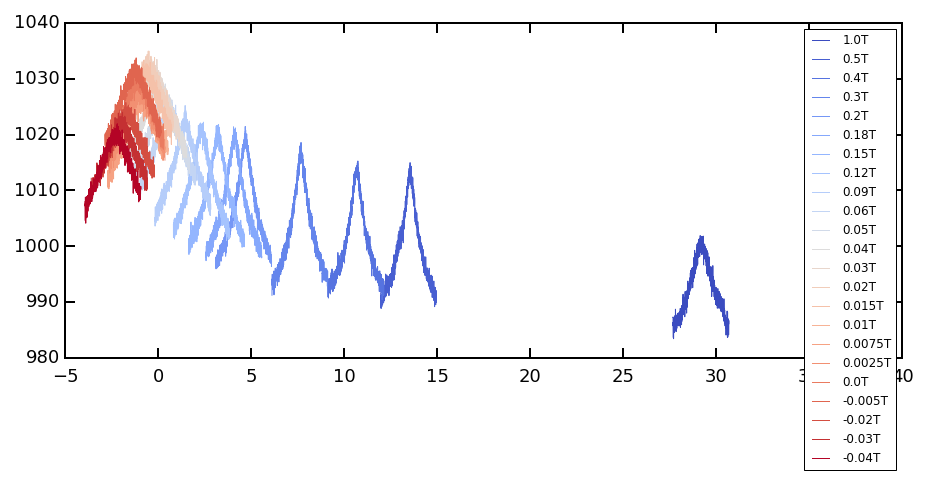

In [102]:
# 1199 - 1223

datnums = [n for n in range(1199, 1223+1, 1)]
fields = [1.0,0.5,0.4,0.3,0.2,0.18,0.15,0.12,0.09,0.06,0.05,
          0.04,0.03,0.02,0.015,0.01,0.0075,0.005,0.0025,0,-0.005,-0.01,-0.02,-0.03,-0.04]
bias = np.ones(len(fields))*1.0
direction = ['mixed' for f in fields]
dat_files = zip(datnums, fields, direction, bias)
df = create_wlcorr_dataframe(dat_files)
df = df[(df.parallel!=-0.01) & (df.parallel!=0.005)]

fig, ax = plt.subplots(1,1, figsize = (15,6))
palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(df))))
for i in range(len(df)):
    
    row = df.iloc[i,:]
    
    scale = 1.0/1000.0/1.5/(row['bias']*1e-9) 
    txx = import_2d_dataset(row['dat'])
    txx.y *= scale
    
    ax.plot(txx.x, txx.y, color = next(palette), label = '{0}T'.format(row['parallel']))
ax.set_xlim(-5, 40)
ax.legend()

Some of the above data showed odd behavior when the B_phi fits were done. A corrected data set is plotted below with some sweeps replaced or taken a second time:

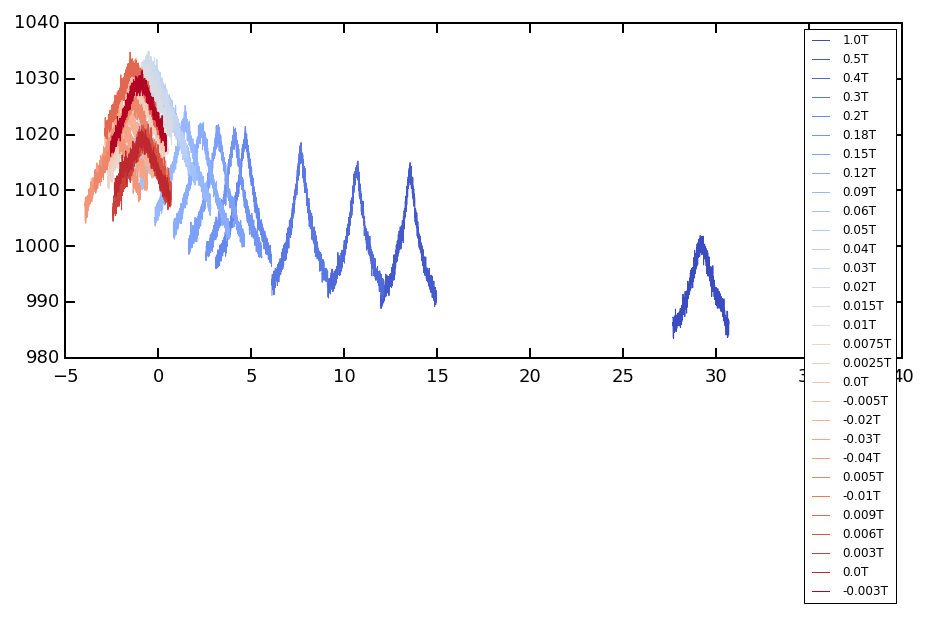

In [103]:
# 1199-1223
# 1196 --  0.005
# 1224 -- -0.01
# 1225-1229 -- [0.009, 0.006, 0.003, 0.000, -0.003]

datnums = [n for n in range(1199, 1223+1, 1)]
datnums.append(1196)
datnums.append(1224)
datnums.extend([n for n in range(1224, 1229+1, 1)])
fields = [1.0,0.5,0.4,0.3,0.2,0.18,0.15,0.12,0.09,0.06,
          0.05,0.04,0.03,0.02,0.015,0.01,0.0075,0.005,0.0025,0,-0.005,-0.01,-0.02,-0.03,-0.04, 
          0.005, -0.01, 0.009, 0.006, 0.003, 0.000, -0.003]
bias = np.ones(len(fields))*1.0
direction = ['mixed' for f in fields]
dat_files = zip(datnums, fields, direction, bias)
df = create_wlcorr_dataframe(dat_files)
remove = [1216, 1220]
df = df[~df['dat'].isin(remove)]

fig, ax = plt.subplots(1,1, figsize = (15,6))
palette = itertools.cycle(plt.cm.coolwarm(np.linspace(0, 1, len(df))))
for i in range(len(df)):
    
    row = df.iloc[i,:]
    
    scale = 1.0/1000.0/1.5/(row['bias']*1e-9) 
    txx = import_2d_dataset(row['dat'])
    txx.y *= scale
    
    ax.plot(txx.x, txx.y, color = next(palette), label = '{0}T'.format(row['parallel']))
ax.set_xlim(-5, 40)
ax.legend()

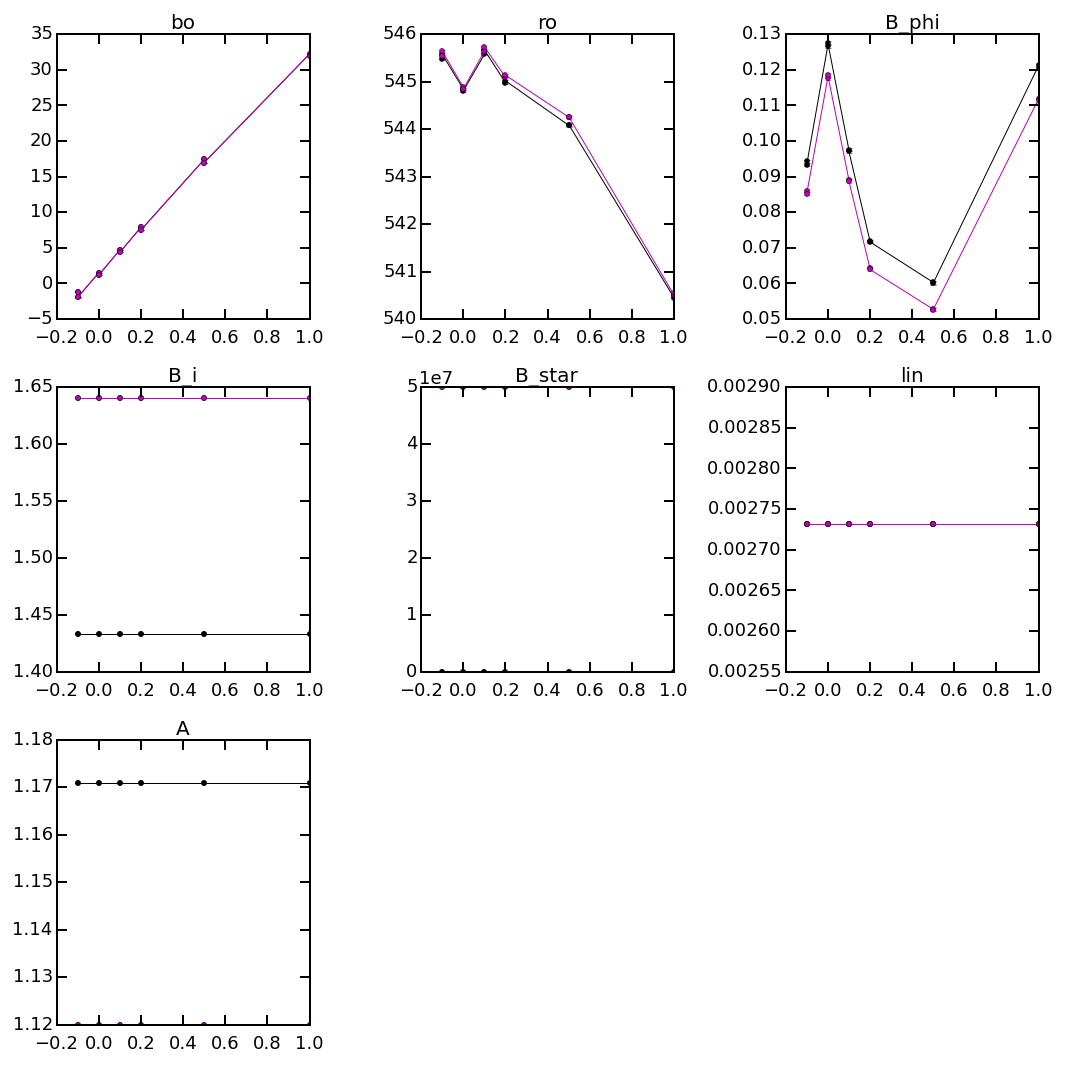

In [326]:
dat_files = [('dat538', -0.1, 'Up', 10),
             ('dat539', -0.1, 'Down', 10),
             ('dat542', 0.0, 'Up', 10),
             ('dat543', 0.0, 'Down', 10),
             ('dat546', 0.1, 'Up', 10),
             ('dat547', 0.1, 'Down', 10),
             ('dat550', 0.2, 'Up', 10), 
             ('dat551', 0.2, 'Down', 10),
             ('dat554', 0.5, 'Up', 10),
             ('dat555', 0.5, 'Down', 10),
             ('dat558', 1.0, 'Up', 10),
             ('dat559', 1.0, 'Down', 10)]

df = create_results_dataframe(dat_files)

fig, axs = plt.subplots(3,3, figsize = (15,15))
ax = axs.flatten()

# round 1, let everything go wild
df = fit_wl_peaks(df, 'fields', 'g6x')
# plot_results(ax, df, color = 'b')

# round 2, hold B_star and lin constant
fix = {'B_star':df['B_star'].mean(), 'lin': df['lin'].mean()}
df = fit_wl_peaks(df, 'fields', 'g6x', fix)
# plot_results(ax, df, color = 'r')

# round 3, hold A, B_star, and lin constant
fix = {'A':df['A'].mean(), 'B_star':df['B_star'].mean(), 'lin': df['lin'].mean()}
df = fit_wl_peaks(df, 'fields', 'g6x', fix)
# plot_results(ax, df, color = 'g')

# round 4, hold A, B_star, and lin constant
fix = {'A':df['A'].mean(), 'B_i':df['B_i'].mean(), 'B_star':df['B_star'].mean(), 'lin': df['lin'].mean()}
df = fit_wl_peaks(df, 'fields', 'g6x', fix)
plot_results(ax, df, color = 'k')
    
# round 5, hold A at 1, fix B_star and lin at mean fit values
fix = {'A':1.12, 'B_i':1.64, 'B_star':5e7, 'lin': df['lin'].mean()}
df = fit_wl_peaks(df, 'fields', 'g6x', fix)
plot_results(ax, df, color = 'm')

ax[-2].axis('off')
ax[-1].axis('off')
fig.tight_layout()

In [876]:
# trying to do curvature fits to silvia's data

# dat762 to dat916
# 1 peak finding sweep plus 6 additional sweeps

(-0.05, 0.5)

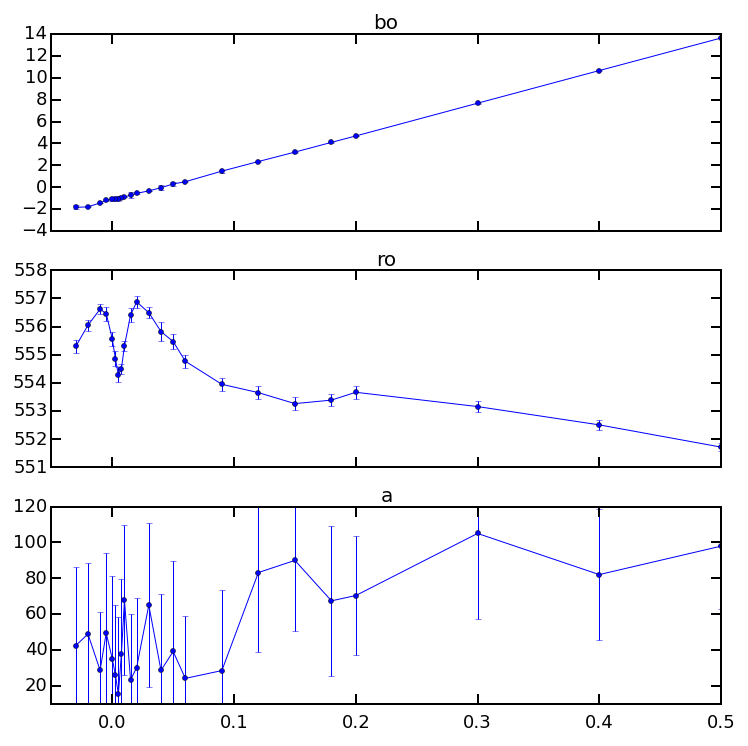

In [882]:
# trying to do curvature fits to silvia's data

# dat943 to dat1057
# 1 peak finding sweep plus 6 additional sweeps

# sort through data... 
datnums = [n for n in range(943, 1057, 5)]
fields = [0.5,0.4,0.3,0.2,0.18,0.15,0.12,0.09,0.06,0.05,0.04,0.03,
          0.02,0.015,0.01,0.0075,0.005,0.0025,0,-0.005,-0.01,-0.02,-0.03]
bias = np.ones(len(fields))*2.0
direction = ['mixed' for f in fields]
dat_files = zip(datnums, fields, direction, bias)
df = create_parabola_dataframe(dat_files)

df = fit_parabola_peaks(df, 4.0, 0.1, fix = None)
fig, ax = plt.subplots(3,1, sharex = True, figsize = (12,12))
plot_results_parabola(ax, df)
ax[-1].set_ylim(10, 120)
ax[-1].set_xlim(-0.05, 0.5)

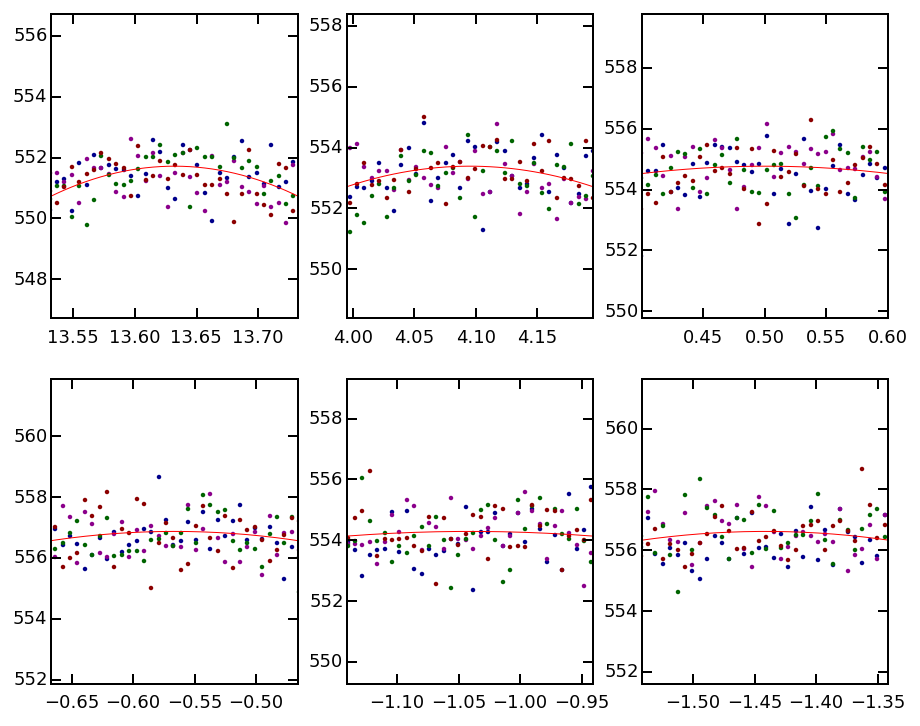

In [879]:
fig, ax = plt.subplots(2,3, figsize = (15, 12))
axs = ax.flatten()
nums = [i for i in range(0,len(df),4)]
for i, n in enumerate(nums):
    plot_fit_result(axs[i], n, 4, df)
    bo = df.loc[n,'bo']
    ro = df.loc[n,'ro']
    axs[i].set_xlim(bo-0.1, bo+0.1)
    axs[i].set_ylim(ro-5.0, ro+5.0)

In [1226]:
# 1097-1182, these numbers are the fast sweeps

direction = ['fast', 'up', 'down', 'up', 'down']
sweeps = len(direction)
datnums = [n for n in range(1097, 1182+int(sweeps))]
fields = [0.5,0.4,0.3,0.2,0.18,0.15,0.12,0.09,0.06,0.05,0.04,0.03,0.02,0.015,0.01, 0.0075, 0.005, 0.0025]
bias = 4.0 # nA

bias_array = np.ones(len(fields)*(int(sweeps)+1))*4.0
dat_files = zip(datnums, np.repeat(fields, int(sweeps)), np.tile(direction, len(fields)), bias_array)

df = create_results_dataframe(dat_files)
df = fit_linear_wl_all(df, 1.0)

Determining the bias dependance of B_phi at T_mix = base, V_BG = 40V, B_parallel = 5mT (effective zero)

[[Model]]
    Model(wlcorr)
[[Fit Statistics]]
    # function evals   = 178
    # data points      = 2818
    # variables        = 7
    chi-square         = 1055.417
    reduced chi-square = 0.375
[[Variables]]
    A:        1.44944106 +/- 0.032304 (2.23%) (init= 1)
    B_i:      1.06653507 +/- 0.055426 (5.20%) (init= 1)
    bo:      -0.53171109 +/- 0.003330 (0.63%) (init=-0.868)
    B_phi:    0.23776889 +/- 0.005817 (2.45%) (init= 0.2)
    lin:     -0.03221183 +/- 0.002435 (7.56%) (init= 0.0027)
    B_star:   1.0639e+05 +/- 4.83e+04 (45.41%) (init= 2.5e+07)
    ro:       1004.79281 +/- 0.052128 (0.01%) (init= 1006)
[[Correlations]] (unreported correlations are <  0.100)
    C(A, B_phi)                  =  0.980 
    C(A, B_i)                    = -0.977 
    C(B_i, B_phi)                = -0.923 
    C(B_phi, ro)                 = -0.754 
    C(A, ro)                     = -0.629 
    C(B_i, ro)                   =  0.527 
    C(bo, lin)                   = -0.452 


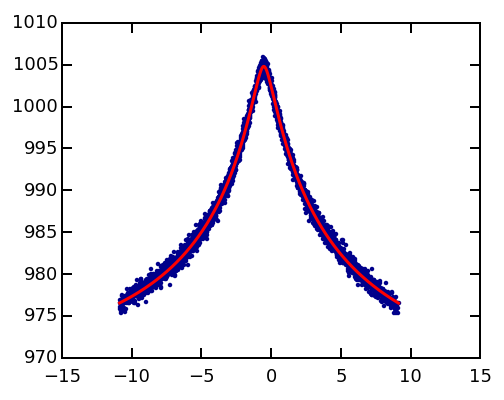

In [108]:
### first get the large field parameters from dat1065, which was a big, gaussian, spaced sweep ###

dat_files = [(1065, 0.005, 'Up', 4.0)]
df = create_wlcorr_dataframe(dat_files)

model = Model(wlcorr, independent_vars=['b'])
params = model.make_params()

row = df.iloc[0,:]
scale = 1.0/1000.0/1.5/(row['bias']*1e-9) 

txx = (Waves('dat{0}g5x.ibw'.format(row['dat'])).as_dataframe(sharex=True)
        +Waves('dat{0}g5x.ibw'.format(row['dat'])).as_dataframe(sharex=True))/2.0
txx.y *= scale
txx.x = Waves('dat{0}fields.ibw'.format(row['dat'])).y

width = 10.0
ro = txx.y.max()
bcenter = txx.x.mean()
high = bcenter+width
low = bcenter-width

txx = txx[(txx.x<high) & (txx.x>low)]

params['bo'].value = round_to(bcenter, 0.001) # round to nearest...
# params['bo'].min = low
# params['bo'].max = high
params['ro'].value = round_to(ro, 0.5)
# params['ro'].min = ro-10.0
# params['ro'].max = ro+10.0
params['B_phi'].value = 0.2
params['B_i'].value = 1.0
params['B_star'].value = 2.5e7
params['lin'].value = 0.0027
params['A'].value = 1.00 

# fit with everything varying to find centers
result = model.fit(txx.y, params, b=txx.x)
print result.fit_report()
        
# save results
for k in result.params:
    df.loc[0,k] += result.params[k].value
    df.loc[0,k+'_stderr'] += result.params[k].stderr
    
fig, ax = plt.subplots(1,1)
ax.scatter(txx.x, txx.y, color = 'darkblue', linewidth = 0)
ax.plot(txx.x, wlcorr(txx.x, **result.values), color = 'r', linewidth = 3)
# result.plot_fit()

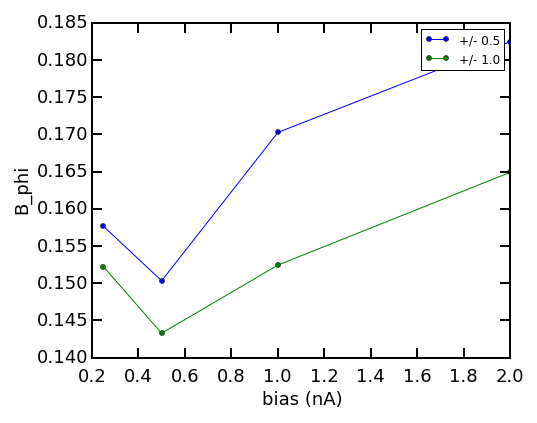

In [347]:
### now hold B_star, lin, A, B_i constant and fit B_phi, bo, ro ###

# these are all 2d waves holding a number of sweeps to average over
dat_files = [(1195, 0.005, 'mixed', 2),
             (1196, 0.005, 'mixed', 1),
             (1197, 0.005, 'mixed', 0.5),
             (1198, 0.005, 'mixed', 0.25)]

fix = {'A': 1.08, 'B_i': 1.75, 'B_star': 2500000.0, 'lin': 0.0027}

fig, ax = plt.subplots(1,1)

df = create_wlcorr_dataframe(dat_files)
df = fit_linear_wl_2d(df, 0.5, fix)
ax.plot(df['bias'], df['B_phi'], marker = 'o', label = '+/- 0.5')

df = create_wlcorr_dataframe(dat_files)
df = fit_linear_wl_2d(df, 1.0, fix)
ax.plot(df['bias'], df['B_phi'], marker = 'o', label = '+/- 1.0')

ax.set_ylabel('B_phi')
ax.set_xlabel('bias (nA)')
ax.legend()

In [305]:
# going to try this without Model() because the rest of lmfit is just a nice wrapper
# for minimize() in scipy.optimize

# get data
dat_files = [(1196, 0.005, 'mixed', 1)]
df = create_wlcorr_dataframe(dat_files)

row = df.iloc[0,:]
scale = 1.0/1000.0/1.5/(row['bias']*1e-9) 
txx = import_2d_dataset(row['dat'])
txx.y *= scale

width = 1.0
ro = txx.y.max()
bcenter = txx.x.mean()
high = bcenter+width
low = bcenter-width
print low, bcenter, high

txx = txx[(txx.x<high) & (txx.x>low)]

# here we go... 
from lmfit import Parameters, minimize, fit_report

def wl_residual(params, b, data):
    # unpack parameters:
    # extract .value attribute for each parameter
    paramvals = params.valuesdict()
    bo = paramvals['bo']
    ro = paramvals['ro']
    B_phi = paramvals['B_phi']
    B_i = paramvals['B_i']
    B_star = paramvals['B_star']
    lin = paramvals['lin']
    A = paramvals['A']

    model = wlcorr(b, bo, ro, B_phi, B_i, B_star, lin, A)
    return (model - data)

    
p = Parameters()
#          (Name, Value, Vary, Min, Max, Expr)
p.add_many(('bo', round_to(bcenter, 0.001), True, None, None, None),
           ('ro', round_to(ro, 0.5), True, None, None, None),
           ('B_phi', 0.15, True, 0.1, None, None),
           ('B_i', 1.8, True, None, None, None),
           ('B_star', 2.5e6, True, 1.0, 3.0, None),
           ('lin', 0.003, True, None, None, None),
           ('A', 1.00, True, None, None, None))
           
fix = {'A': 1.08, 'B_i': 1.75, 'B_star': 2500000.0, 'lin': 0.0027}
for k in fix:
    p[k].vary = False
    p[k].value = fix[k]

# do fit, here with leastsq model
result = minimize(wl_residual, params, args=(txx.x, txx.y), epsfcn=1e-7) # fails if epsfcn is not specified

# calculate final result
# final = data + result.residual

# write error report
print fit_report(result)

-2.41775348506 -1.41775348506 -0.417753485061
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 3
    chi-square         = 399.923
    reduced chi-square = 0.805
[[Variables]]
    A:        1.08 (fixed)
    B_i:      1.75 (fixed)
    bo:      -1.41672915 +/- 0.005395 (0.38%) (init=-1.418)
    B_phi:    0.15287224 +/- 0.002674 (1.75%) (init= 0.15)
    lin:      0.0027 (fixed)
    B_star:   2500000 (fixed)
    ro:       1026.10862 +/- 0.079870 (0.01%) (init= 1028)
[[Correlations]] (unreported correlations are <  0.100)
    C(B_phi, ro)                 = -0.863 


(-0.05, 0.5)

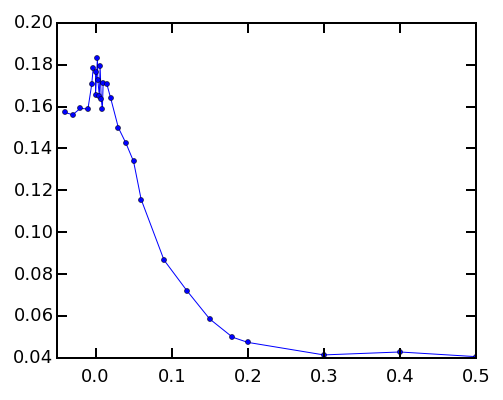

In [235]:
# 1199-1223
# 1196 --  0.005
# 1224 -- -0.01
# 1225-1229 -- [0.009, 0.006, 0.003, 0.000, -0.003]

datnums = [n for n in range(1199, 1223+1, 1)]
datnums.append(1196)
datnums.append(1224)
datnums.extend([n for n in range(1224, 1229+1, 1)])
fields = [1.0,0.5,0.4,0.3,0.2,0.18,0.15,0.12,0.09,0.06,
          0.05,0.04,0.03,0.02,0.015,0.01,0.0075,0.005,0.0025,0,-0.005,-0.01,-0.02,-0.03,-0.04, 
          0.005, -0.01, 0.009, 0.006, 0.003, 0.000, -0.003]
bias = np.ones(len(fields))*1.0
direction = ['mixed' for f in fields]
dat_files = zip(datnums, fields, direction, bias)
df = create_wlcorr_dataframe(dat_files)
remove = [1216, 1220]
df = df[~df['dat'].isin(remove)]

fix = {'A': 1.08, 'B_i': 1.75, 'B_star': 2500000.0, 'lin': 0.0027}

dfa = fit_linear_wl_2d(df, 5.0) # find centers
dfb = fit_linear_wl_2d(dfa, 0.6, fix)

dfb.sort(columns='parallel', axis=0, ascending=True, inplace=True)
fig, ax = plt.subplots(1,1)
ax.plot(dfb.parallel, dfb.B_phi, color = 'b', marker = 'o')
ax.set_xlim(-0.05, 0.5)

(-0.05, 0.1)

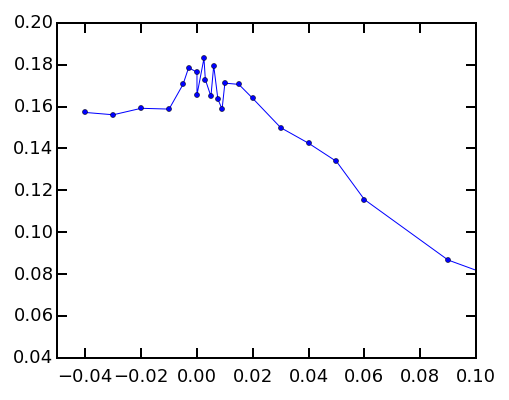

In [238]:
fig, ax = plt.subplots(1,1)
ax.plot(dfb.parallel, dfb.B_phi, color = 'b', marker = 'o')
ax.set_xlim(-0.05, 0.1)

<IPython.core.display.Javascript object>


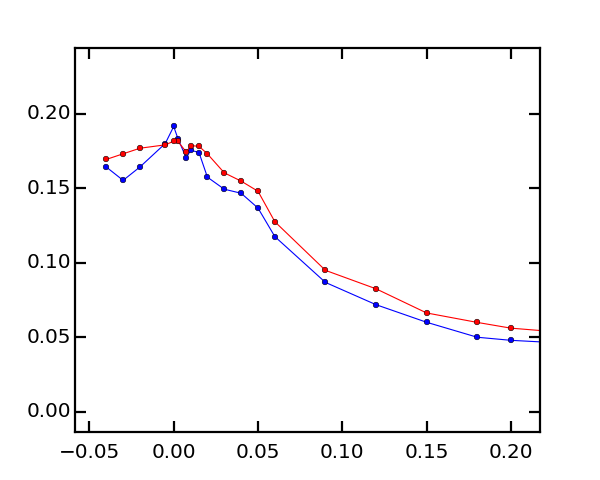

(-0.05, 0.1)

In [366]:
### test of different fitting methods ###
# blue curve -- fit to find centers, then take that fit and look at a +/-0.5mT range. 
# red curve -- fit to find centers and ro, then look at all data within 0.5% of ro
# red curve tends to overestimate B_phi
# blue curve depends heavily on what range is used

fig, ax = plt.subplots(1,1)
ax.plot(find_centers.parallel, find_centers.B_phi, color = 'b', marker = 'o')
ax.plot(find_tops.parallel, find_tops.B_phi, color = 'r', marker = 'o')
ax.set_xlim(-0.05, 0.1)

<IPython.core.display.Javascript object>


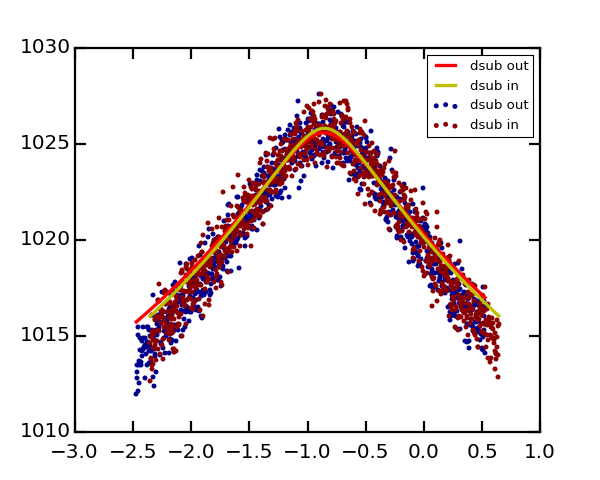

0    0.175236
1    0.164388
Name: B_phi, dtype: float64


In [395]:
# looking for any change with the dsub (IGH) connector removed/not removed

dat_files = [(1239, 0.005, 'dsub out', 1.0),
             (1238, 0.005, 'dsub in', 1.0)]
df = create_wlcorr_dataframe(dat_files)

fix = {'A': 1.08, 'B_i': 1.75, 'B_star': 2500000.0, 'lin': 0.0027}

dfa = fit_linear_wl_2d(df, 5.0) # find centers
dfb = fit_linear_wl_2d(dfa, 0.6, fix)

fig, ax = plt.subplots(1,1)
plot_fit_result(ax, 0, dfb, color = 1, label = 'dsub out')
plot_fit_result(ax, 1, dfb, color = 2, label = 'dsub in')
ax.legend()

print dfb['B_phi']

## Checking Bias and Temperature Dependence

Plus: a calibration for the lockin measurements

#### December 1-2:

Measurements of bias dependance and peak shapes as a fucntion of temperature. Get temperatures from mixchtemp.

In [309]:
# Repeated measurements at constant bias

dat_files =[(1247, 300.0, 2.0, 0.005, -44.855), (1248, 300.0, 2.0, 0.005, -44.855), 
            (1249, 300.0, 2.0, 0.005, -44.855), (1250, 300.0, 2.0, 0.005, -44.855), 
            (1251, 300.0, 2.0, 0.005, -44.855), (1262, 300.0, 1.0, 0.005, -44.855),
            (1263, 300.0, 1.0, 0.005, -44.855), (1264, 300.0, 1.0, 0.005, -44.855), 
            (1265, 300.0, 1.0, 0.005, -44.855), (1266, 300.0, 1.0, 0.005, -44.855), 
            (1279, 300.0, 1.0, 0.005, -44.855), (1280, 300.0, 1.0, 0.005, -44.855),
            (1281, 300.0, 1.0, 0.005, -44.855), (1282, 300.0, 1.0, 0.005, -44.855), 
            (1283, 300.0, 1.0, 0.005, -44.855), (1294, 300.0, 1.0, 0.005, -44.855), 
            (1295, 300.0, 1.0, 0.005, -44.855), (1296, 300.0, 1.0, 0.005, -44.855),
            (1297, 300.0, 1.0, 0.005, -44.855), (1298, 300.0, 1.0, 0.005, -44.855),
            (1309, 300.0, 1.0, 0.005, -44.855), (1310, 300.0, 1.0, 0.005, -44.855),
            (1311, 300.0, 1.0, 0.005, -44.855), (1312, 300.0, 1.0, 0.005, -44.855),
            (1313, 300.0, 1.0, 0.005, -44.855), (1324, 300.0, 1.0, 0.005, -44.855),
            (1325, 300.0, 1.0, 0.005, -44.855), (1326, 300.0, 1.0, 0.005, -44.855),
            (1327, 300.0, 1.0, 0.005, -44.855), (1328, 300.0, 1.0, 0.005, -44.855)]

with open('R-bias_120215_a.pkl','a') as f:
    pickle.dump(dat_files, f)

df = create_generic_dataframe(dat_files)
fill_generic_dataframe(df, calibrate = True)

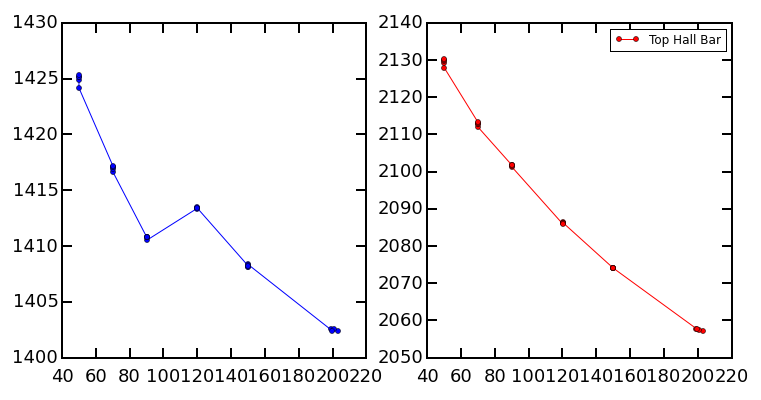

In [310]:
# plot resistance as a function of temperature only where Tmix is relatively stable

dfa = df[df['Tmix_stderr']<1.5]

fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].plot(dfa['Tmix'], dfa['Rtop'], color = 'b', marker = 'o', label = 'Bottom Hall Bar')
ax[1].plot(dfa['Tmix'], dfa['Rbtm'], color = 'r', marker = 'o', label = 'Top Hall Bar')
ax[1].legend()

In [311]:
# Measurements of resistance over time at fixed temperature, varying bias

dat_files =[(1252, 300.0, 0.5, 0.005, -44.855), (1253, 300.0, 1.0, 0.005, -44.855), 
            (1254, 300.0, 2.0, 0.005, -44.855), (1255, 300.0, 5.0, 0.005, -44.855), 
            (1256, 300.0, 10.0, 0.005, -44.855), (1257, 300.0, 20.0, 0.005, -44.855),
            (1267, 300.0, 0.5, 0.005, -44.855), (1268, 300.0, 1.0, 0.005, -44.855), 
            (1269, 300.0, 2.0, 0.005, -44.855), (1270, 300.0, 5.0, 0.005, -44.855), 
            (1271, 300.0, 10.0, 0.005, -44.855), (1272, 300.0, 20.0, 0.005, -44.855),
            (1284, 300.0, 0.5, 0.005, -44.855), (1285, 300.0, 0.8, 0.005, -44.855), 
            (1286, 300.0, 1.0, 0.005, -44.855), (1287, 300.0, 2.0, 0.005, -44.855), 
            (1288, 300.0, 5.0, 0.005, -44.855), (1289, 300.0, 8.0, 0.005, -44.855),
            (1290, 300.0, 10.0, 0.005, -44.855), (1291, 300.0, 15.0, 0.005, -44.855),
            (1292, 300.0, 20.0, 0.005, -44.855), (1299, 300.0, 0.5, 0.005, -44.855),
            (1311, 300.0, 1.0, 0.005, -44.855), (1312, 300.0, 1.0, 0.005, -44.855),
            (1300, 300.0, 0.8, 0.005, -44.855), (1301, 300.0, 1.0, 0.005, -44.855),
            (1302, 300.0, 2.0, 0.005, -44.855), (1303, 300.0, 5.0, 0.005, -44.855),
            (1304, 300.0, 8.0, 0.005, -44.855), (1305, 300.0, 10.0, 0.005, -44.855),
            (1306, 300.0, 15.0, 0.005, -44.855), (1307, 300.0, 20.0, 0.005, -44.855),
            (1314, 300.0, 0.5, 0.005, -44.855), (1315, 300.0, 0.8, 0.005, -44.855),
            (1316, 300.0, 1.0, 0.005, -44.855), (1317, 300.0, 2.0, 0.005, -44.855),
            (1318, 300.0, 5.0, 0.005, -44.855), (1319, 300.0, 8.0, 0.005, -44.855),
            (1320, 300.0, 10.0, 0.005, -44.855), (1321, 300.0, 15.0, 0.005, -44.855),
            (1322, 300.0, 20.0, 0.005, -44.855), (1329, 300.0, 0.5, 0.005, -44.855),
            (1330, 300.0, 0.8, 0.005, -44.855), (1331, 300.0, 1.0, 0.005, -44.855),
            (1332, 300.0, 2.0, 0.005, -44.855), (1333, 300.0, 5.0, 0.005, -44.855),
            (1334, 300.0, 8.0, 0.005, -44.855), (1335, 300.0, 10.0, 0.005, -44.855),
            (1336, 300.0, 15.0, 0.005, -44.855), (1337, 300.0, 20.0, 0.005, -44.855)]

with open('R-bias_120215_b.pkl','a') as f:
    pickle.dump(dat_files, f)

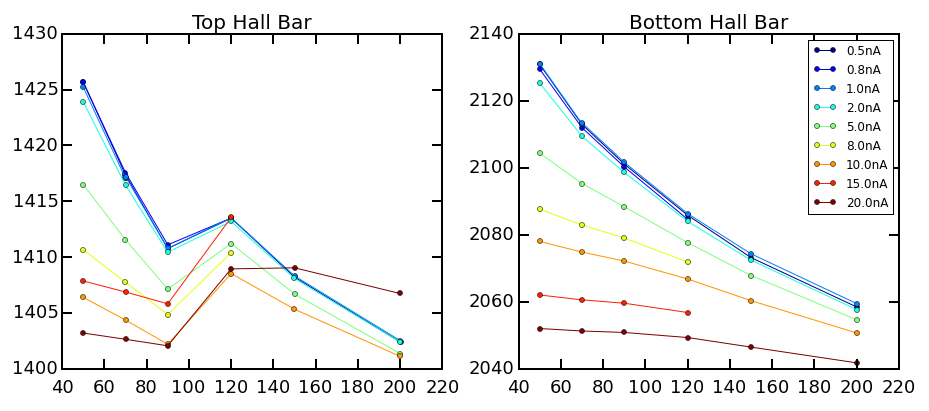

In [317]:
df = create_generic_dataframe(dat_files)
fill_generic_dataframe(df, calibrate = True)
df.sort(columns='Tset', axis=0, ascending=True, inplace=True)

fig, ax = plt.subplots(1,2, figsize = (15,6))

bias = [0.5, 0.8, 1.0, 2.0, 5.0, 8.0, 10.0, 15.0, 20.0]

palette = itertools.cycle(plt.cm.jet(np.linspace(0, 1, len(bias))))
for b in bias:

    dfa = df[df['bias']==b]
    
    c = next(palette)
    ax[0].plot(dfa['Tmix'], dfa['Rtop'], color = c, marker = 'o', label = '{0}nA'.format(b))
    ax[1].plot(dfa['Tmix'], dfa['Rbtm'], color = c, marker = 'o', label = '{0}nA'.format(b))
    
ax[0].set_title('Top Hall Bar')
ax[1].set_title('Bottom Hall Bar')
ax[1].legend()

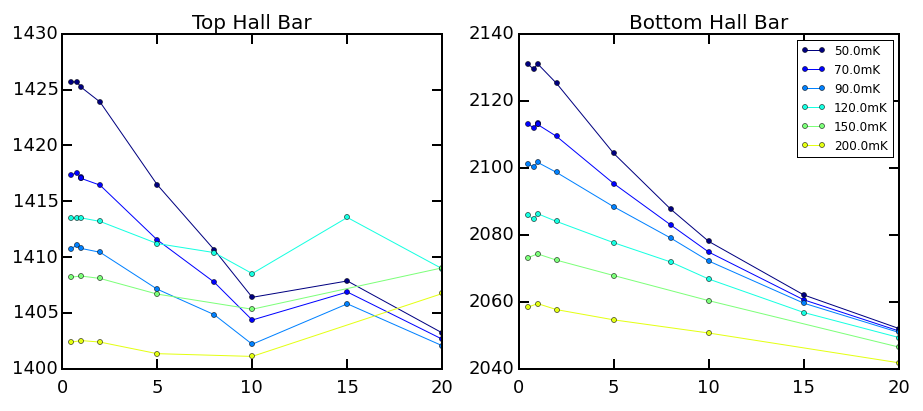

In [314]:
df = create_generic_dataframe(dat_files)
fill_generic_dataframe(df, calibrate = True)
df.sort(columns='bias', axis=0, ascending=True, inplace=True)

fig, ax = plt.subplots(1,2, figsize = (15,6))

Ts = [50.0, 70.0, 90.0, 120.0, 150.0, 200.0]

palette = itertools.cycle(plt.cm.jet(np.linspace(0, 1, len(bias))))
for T in Ts:

    dfa = df[df['Tset']==T]
    
    c = next(palette)
    ax[0].plot(dfa['bias'], dfa['Rtop'], color = c, marker = 'o', label = '{0}mK'.format(T))
    ax[1].plot(dfa['bias'], dfa['Rbtm'], color = c, marker = 'o', label = '{0}mK'.format(T))
    
ax[0].set_title('Top Hall Bar')
ax[1].set_title('Bottom Hall Bar')
ax[1].legend()

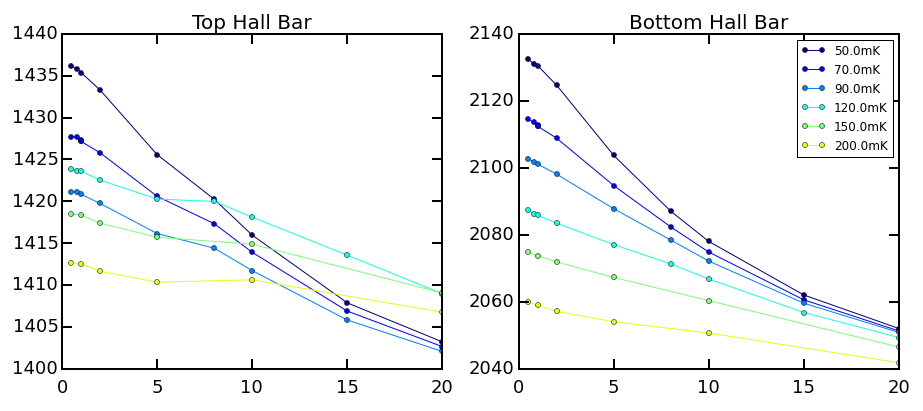

In [315]:
df = create_generic_dataframe(dat_files)
fill_generic_dataframe(df, calibrate = False)
df.sort(columns='bias', axis=0, ascending=True, inplace=True)

fig, ax = plt.subplots(1,2, figsize = (15,6))

Ts = [50.0, 70.0, 90.0, 120.0, 150.0, 200.0]
# Ts = [120.0, 150.0, 200.0]

palette = itertools.cycle(plt.cm.jet(np.linspace(0, 1, len(bias))))
for T in Ts:

    dfa = df[df['Tset']==T]
    
    c = next(palette)
    ax[0].plot(dfa['bias'], dfa['Rtop'], color = c, marker = 'o', label = '{0}mK'.format(T))
    ax[1].plot(dfa['bias'], dfa['Rbtm'], color = c, marker = 'o', label = '{0}mK'.format(T))
    
ax[0].set_title('Top Hall Bar')
ax[1].set_title('Bottom Hall Bar')
ax[1].legend()

### Lockin Calibration

Calibrating a 1kOhm resistor. Bias and lockin ranges change with each data point.

In [215]:
# # srs6 calibration
# # this won't work unless you edit fill generic dataframe to use only srs6 to calculate Rtop

# dat_files =[(1340, 300.0, 0.5, 0.0, 0.0), (1341, 0.0, 0.8, 0.0, 0.0), 
#             (1342, 300.0, 1.0, 0.0, 0.0), (1343, 0.0, 2.0, 0.0, 0.0),
#             (1344, 300.0, 5.0, 0.0, 0.0), (1345, 0.0, 8.0, 0.0, 0.0),
#             (1346, 300.0, 10.0, 0.0, 0.0), (1347, 0.0, 15.0, 0.0, 0.0),
#             (1348, 300.0, 20.0, 0.0, 0.0)]

# bias = [0.5, 0.8, 2.0, 5.0, 8.0, 15.0]

# df = create_generic_dataframe(dat_files)
# fill_generic_dataframe(df)
# rcal = df[df['bias'].isin(bias)]

# print (998.8/rcal['Rtop'])

In [216]:
# # srs5 calibration
# # this won't work unless you edit fill generic dataframe to use only srs5 to calculate Rtop

# dat_files =[(1349, 300.0, 0.5, 0.0, 0.0), (1350, 0.0, 0.8, 0.0, 0.0), (1351, 0.0, 2.0, 0.0, 0.0),
#             (1352, 300.0, 5.0, 0.0, 0.0), (1353, 0.0, 8.0, 0.0, 0.0), (1354, 300.0, 15.0, 0.0, 0.0)]

# bias = [0.5, 0.8, 2.0, 5.0, 8.0, 15.0]

# df = create_generic_dataframe(dat_files)
# fill_generic_dataframe(df)
# rcal = df[df['bias'].isin(bias)]

# print (-998.8/rcal['Rtop'])

In [217]:
# # srs8 calibration
# # this won't work unless you edit fill generic dataframe to use only srs5 to calculate Rtop

# dat_files =[(1355, 300.0, 0.5, 0.0, 0.0), (1356, 0.0, 0.8, 0.0, 0.0), (1357, 0.0, 2.0, 0.0, 0.0),
#             (1358, 300.0, 5.0, 0.0, 0.0), (1359, 0.0, 8.0, 0.0, 0.0), (1360, 300.0, 15.0, 0.0, 0.0)]

# bias = [0.5, 0.8, 2.0, 5.0, 8.0, 15.0]

# df = create_generic_dataframe(dat_files)
# fill_generic_dataframe(df)
# rcal = df[df['bias'].isin(bias)]

# print (998.8/rcal['Rbtm'])

###### December 2-3:

Measurements of bias dependance and peak shapes as a fucntion of temperature. Get temperatures from mixchtemp.

In [318]:
dat_files =[(1373, 300.0, 1.0, 0.005, -44.855), (1374, 300.0, 1.0, 0.005, -44.855), 
            (1375, 300.0, 1.0, 0.005, -44.855), (1376, 300.0, 1.0, 0.005, -44.855), 
            (1377, 300.0, 1.0, 0.005, -44.855), (1385, 300.0, 1.0, 0.005, -44.855),
            (1386, 300.0, 1.0, 0.005, -44.855), (1387, 300.0, 1.0, 0.005, -44.855), 
            (1388, 300.0, 1.0, 0.005, -44.855), (1389, 300.0, 1.0, 0.005, -44.855), 
            (1397, 300.0, 1.0, 0.005, -44.855), (1398, 300.0, 1.0, 0.005, -44.855),
            (1399, 300.0, 1.0, 0.005, -44.855), (1400, 300.0, 1.0, 0.005, -44.855), 
            (1401, 300.0, 1.0, 0.005, -44.855), (1409, 300.0, 1.0, 0.005, -44.855), 
            (1410, 300.0, 1.0, 0.005, -44.855), (1411, 300.0, 1.0, 0.005, -44.855),
            (1412, 300.0, 1.0, 0.005, -44.855), (1413, 300.0, 1.0, 0.005, -44.855),
            (1361, 300.0, 1.0, 0.005, -44.855), (1362, 300.0, 1.0, 0.005, -44.855),
            (1363, 300.0, 1.0, 0.005, -44.855), (1364, 300.0, 1.0, 0.005, -44.855),
            (1365, 300.0, 1.0, 0.005, -44.855), (1421, 300.0, 1.0, 0.005, -44.855),
            (1422, 300.0, 1.0, 0.005, -44.855), (1423, 300.0, 1.0, 0.005, -44.855),
            (1424, 300.0, 1.0, 0.005, -44.855), (1425, 300.0, 1.0, 0.005, -44.855)]

with open('R-bias_120315_a.pkl','a') as f:
    pickle.dump(dat_files, f)

df = create_generic_dataframe(dat_files)
fill_generic_dataframe(df, calibrate = True)

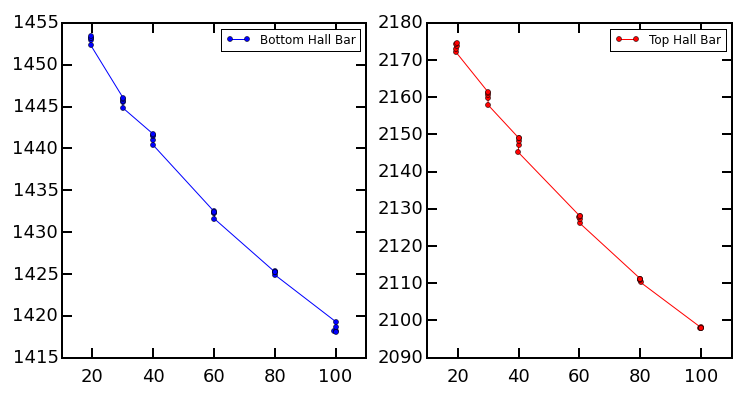

In [319]:
dfa = df[df['Tmix_stderr']<0.5]

fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].plot(dfa['Tmix'], dfa['Rtop'], color = 'b', marker = 'o', label = 'Bottom Hall Bar')
ax[1].plot(dfa['Tmix'], dfa['Rbtm'], color = 'r', marker = 'o', label = 'Top Hall Bar')
ax[0].legend()
ax[1].legend()

I think we learn here that the sample definitely cools much faster than the mixign chamber

In [320]:
# Measurements of resistance over time at fixed temperature, varying bias

dat_files =[(1378, 300.0, 0.4, 0.005, -44.855), (1379, 300.0, 0.8, 0.005, -44.855), 
            (1380, 300.0, 1.6, 0.005, -44.855), (1381, 300.0, 4.0, 0.005, -44.855), 
            (1382, 300.0, 8.0, 0.005, -44.855), (1383, 300.0, 16.0, 0.005, -44.855),
           (1390, 300.0, 0.4, 0.005, -44.855), (1391, 300.0, 0.8, 0.005, -44.855), 
            (1392, 300.0, 1.6, 0.005, -44.855), (1393, 300.0, 4.0, 0.005, -44.855), 
            (1394, 300.0, 8.0, 0.005, -44.855), (1395, 300.0, 16.0, 0.005, -44.855),
           (1402, 300.0, 0.4, 0.005, -44.855), (1403, 300.0, 0.8, 0.005, -44.855), 
            (1404, 300.0, 1.6, 0.005, -44.855), (1405, 300.0, 4.0, 0.005, -44.855), 
            (1406, 300.0, 8.0, 0.005, -44.855), (1407, 300.0, 16.0, 0.005, -44.855),
           (1414, 300.0, 0.4, 0.005, -44.855), (1415, 300.0, 0.8, 0.005, -44.855), 
            (1416, 300.0, 1.6, 0.005, -44.855), (1417, 300.0, 4.0, 0.005, -44.855), 
            (1418, 300.0, 8.0, 0.005, -44.855), (1419, 300.0, 16.0, 0.005, -44.855),
           (1366, 300.0, 0.4, 0.005, -44.855), (1367, 300.0, 0.8, 0.005, -44.855), 
            (1368, 300.0, 1.6, 0.005, -44.855), (1369, 300.0, 4.0, 0.005, -44.855), 
            (1370, 300.0, 8.0, 0.005, -44.855), (1371, 300.0, 16.0, 0.005, -44.855),
           (1426, 300.0, 0.4, 0.005, -44.855), (1427, 300.0, 0.8, 0.005, -44.855), 
            (1428, 300.0, 1.6, 0.005, -44.855), (1429, 300.0, 4.0, 0.005, -44.855), 
            (1430, 300.0, 8.0, 0.005, -44.855), (1431, 300.0, 16.0, 0.005, -44.855),]

with open('R-bias_120315_b.pkl','a') as f:
    pickle.dump(dat_files, f)

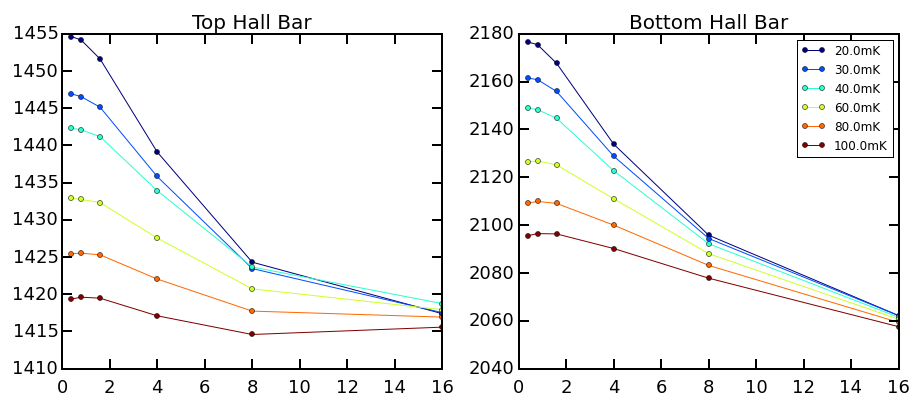

In [321]:
df = create_generic_dataframe(dat_files)
fill_generic_dataframe(df, calibrate = True)
df.sort(columns='bias', axis=0, ascending=True, inplace=True)

fig, ax = plt.subplots(1,2, figsize = (15,6))

Ts = [20.0, 30.0, 40.0, 60.0, 80.0, 100.0]

palette = itertools.cycle(plt.cm.jet(np.linspace(0, 1, len(Ts))))
for T in Ts:

    dfa = df[df['Tset']==T]
    
    c = next(palette)
    ax[0].plot(dfa['bias'], dfa['Rtop'], color = c, marker = 'o', label = '{0}mK'.format(T))
    ax[1].plot(dfa['bias'], dfa['Rbtm'], color = c, marker = 'o', label = '{0}mK'.format(T))
    
ax[0].set_title('Top Hall Bar')
ax[1].set_title('Bottom Hall Bar')
ax[1].legend()

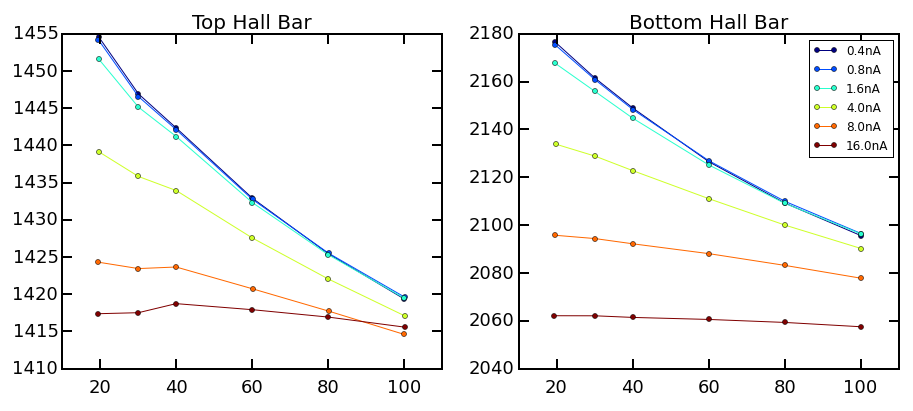

In [322]:
df = create_generic_dataframe(dat_files)
fill_generic_dataframe(df, calibrate = True)
df.sort(columns='Tset', axis=0, ascending=True, inplace=True)

fig, ax = plt.subplots(1,2, figsize = (15,6))

bias = [0.4, 0.8, 1.6, 4.0, 8.0, 16.0]


palette = itertools.cycle(plt.cm.jet(np.linspace(0, 1, len(bias))))
for b in bias:

    dfa = df[df['bias']==b]
    
    c = next(palette)
    ax[0].plot(dfa['Tmix'], dfa['Rtop'], color = c, marker = 'o', label = '{0}nA'.format(b))
    ax[1].plot(dfa['Tmix'], dfa['Rbtm'], color = c, marker = 'o', label = '{0}nA'.format(b))
    
ax[0].set_title('Top Hall Bar')
ax[1].set_title('Bottom Hall Bar')
ax[1].legend()

Make the same plot as above with the data from Dec 2 and 3.

In [323]:
with open('R-bias_120215_b.pkl','r') as f:
    dat_files = pickle.load(f)
    
with open('R-bias_120315_b.pkl','r') as f:
    dat_files.extend(pickle.load(f))

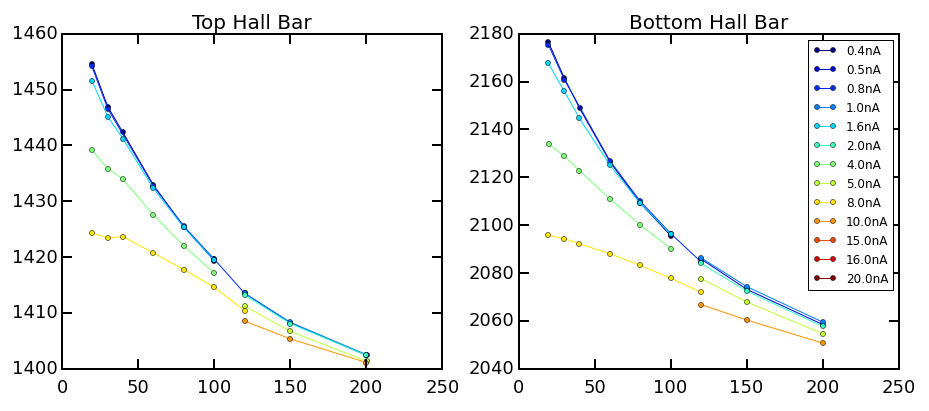

In [326]:
df = create_generic_dataframe(dat_files)
fill_generic_dataframe(df, calibrate = True)
df.sort(columns='Tset', axis=0, ascending=True, inplace=True)

# throw out a bunch of garbage
removeT = [50.0, 70.0, 90.0]
removeB = [15.0, 16.0, 20.0]
df = df[~df['Tset'].isin(removeT)]
df = df[~df['bias'].isin(removeB)]

fig, ax = plt.subplots(1,2, figsize = (15,6))

bias = [0.4, 0.5, 0.8, 1.0, 1.6, 2.0, 4.0, 5.0, 8.0, 10.0, 15.0, 16.0, 20.0]

palette = itertools.cycle(plt.cm.jet(np.linspace(0, 1, len(bias))))
for b in bias:

    dfa = df[df['bias']==b]
    
    c = next(palette)
    ax[0].plot(dfa['Tmix'], dfa['Rtop'], color = c, marker = 'o', label = '{0}nA'.format(b))
    ax[1].plot(dfa['Tmix'], dfa['Rbtm'], color = c, marker = 'o', label = '{0}nA'.format(b))
    
ax[0].set_title('Top Hall Bar')
ax[1].set_title('Bottom Hall Bar')
ax[1].legend()

Going to use the data from Dec 3 to create some interpolation to find real temperatures of the 1nA points.

In [329]:
# import the dataset
with open('R-bias_120315_b.pkl','r') as f:
    dat_files = pickle.load(f)
df = create_generic_dataframe(dat_files)
fill_generic_dataframe(df, calibrate = True)

(19, 40)

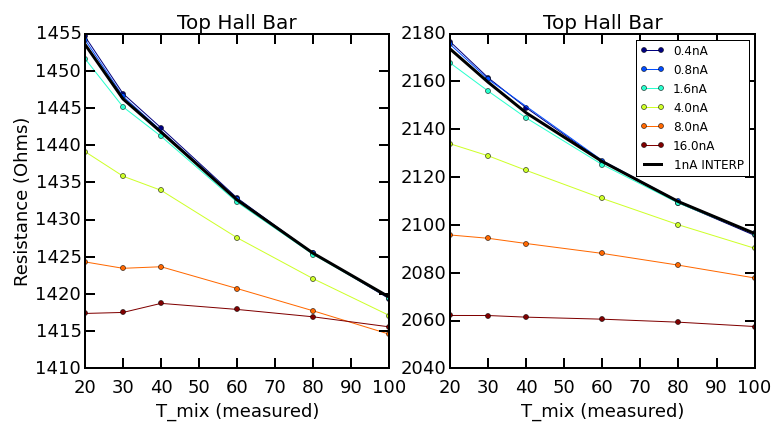

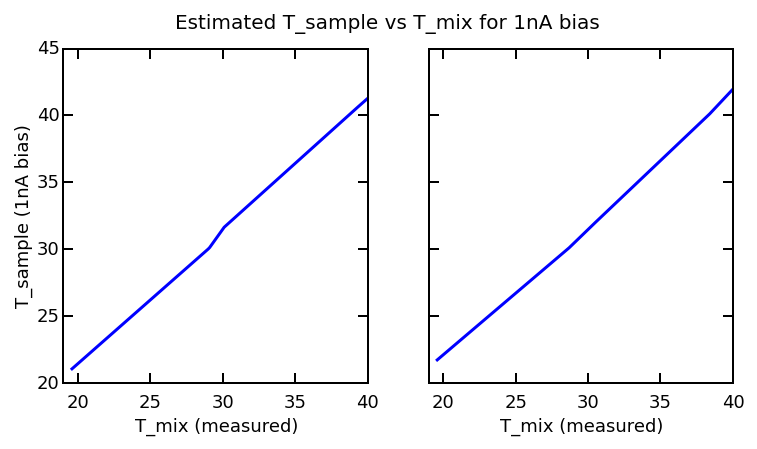

In [420]:
# at each Tset find the resistance one would expect for 1nA
from scipy import interpolate
df.sort(columns='Tset', axis=0, ascending=True, inplace=True)

Ts = [100, 80, 60, 40, 30, 20]
T_meas = np.array([100.0, 80.0, 60.1, 40.0, 30.1, 19.6])
bias = [0.4, 0.8, 1.6, 4.0, 8.0, 16.0]

oneTop = np.zeros(len(Ts))
oneBottom = np.zeros(len(Ts))

for i, T in enumerate(Ts):
    dfa = df[df['Tset']==T]
    funT = interpolate.interp1d(dfa['bias'], dfa['Rtop'])
    oneTop[i] = funT(1.0)   # use interpolation function returned by `interp1d`
    
    funB = interpolate.interp1d(dfa['bias'], dfa['Rbtm'])
    oneBottom[i] = funB(1.0)

fig, ax = plt.subplots(1,2, figsize = (12,6))
palette = itertools.cycle(plt.cm.jet(np.linspace(0, 1, len(bias))))
for b in bias:
    dfa = df[df['bias']==b]
    
    c = next(palette)
    ax[0].plot(dfa['Tset'], dfa['Rtop'], color = c, marker = 'o', label = '{0}nA'.format(b))
    ax[1].plot(dfa['Tset'], dfa['Rbtm'], color = c, marker = 'o', label = '{0}nA'.format(b))
ax[0].plot(Ts, oneTop, color = 'k', linewidth = 3)
ax[1].plot(Ts, oneBottom, color = 'k', linewidth = 3, label = '1nA INTERP')
ax[0].set_xlabel('T_mix (measured)')
ax[1].set_xlabel('T_mix (measured)')
ax[0].set_ylabel('Resistance (Ohms)')
ax[0].set_title('Top Hall Bar')
ax[1].set_title('Top Hall Bar')
ax[1].legend()

# the results of the above 
oneTop = np.array([1419.56695051, 1425.458926, 1432.63141223, 1441.75202925, 1446.20749873, 1453.54268024])
oneBottom = np.array([2096.41727714, 2109.70171151, 2126.44471251, 2146.79729493, 2159.60049596, 2173.49885922])

# now interpolate along those lines at a lot more points 
fun_resT = interpolate.interp1d(T_meas[::-1], oneTop[::-1])
fun_resB = interpolate.interp1d(T_meas[::-1], oneBottom[::-1])
temps = np.arange(19.6, 60.0, 0.1)
Rtop_meas = fun_resT(temps) # returns resistance of top hall bar at Tmix and 1nA bias
Rbtm_meas = fun_resB(temps) # returns resistance of bottom hall bar at Tmix and 1nA bias

# I measure R at 1nA... then I look on the 0.4nA curve and see what T that R corresponds to
dfa = df[df['bias']==0.4].sort(columns='Tmix', axis=0, ascending=False, inplace=False)
fun_tempT = interpolate.interp1d(dfa['Rtop'], dfa['Tmix'])
fun_tempB = interpolate.interp1d(dfa['Rbtm'], dfa['Tmix'])

sampleT_top = fun_tempT(Rtop_meas)
sampleT_btm = fun_tempB(Rbtm_meas)

sample_temp_results = pd.DataFrame(np.column_stack((temps, sampleT_top, sampleT_btm)),
                                   columns = ['T_mix', 'T_sample_top', 'T_sample_bottom'])
sample_temp_results.to_csv('T_sample_calibration_1nA_bias.csv')

fig, ax = plt.subplots(1,2, figsize = (12,6), sharey=True)
ax[0].plot(temps, sampleT_top, linewidth = 3, label='Top Hall Bar')
ax[1].plot(temps, sampleT_btm, linewidth = 3, label='Bottom Hall Bar')

fig.suptitle('Estimated T_sample vs T_mix for 1nA bias')
ax[0].set_ylabel('T_sample (1nA bias)')
ax[0].set_xlabel('T_mix (measured)')
ax[1].set_xlabel('T_mix (measured)')
ax[0].set_xlim(19, 40)
ax[0].set_ylim(20, 45)
ax[1].set_xlim(19, 40)

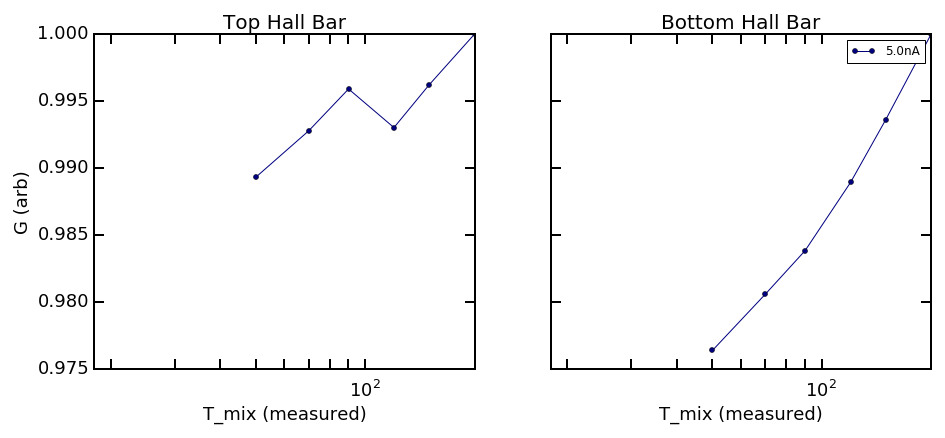

In [108]:
# check if these plots are linear in R vs log(T)
with open('R-bias_120215_b.pkl','r') as f:
    dat_files = pickle.load(f)

df = create_generic_dataframe(dat_files)
fill_generic_dataframe(df, calibrate = True)
df.sort(columns='Tset', axis=0, ascending=True, inplace=True)

fig, ax = plt.subplots(1,2, figsize = (15,6), sharey=True)

bias = [5.0]

palette = itertools.cycle(plt.cm.jet(np.linspace(0, 1, len(bias))))
for b in bias:

    dfa = df[df['bias']==b]
    
    c = next(palette)
    ax[0].plot(dfa['Tmix'], dfa['Rtop'].min()/dfa['Rtop'], color = c, marker = 'o', label = '{0}nA'.format(b))
    ax[1].plot(dfa['Tmix'], dfa['Rbtm'].min()/dfa['Rbtm'], color = c, marker = 'o', label = '{0}nA'.format(b))

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlim(18, 200)
ax[1].set_xlim(18, 200)
ax[0].set_title('Top Hall Bar')
ax[1].set_title('Bottom Hall Bar')
ax[0].set_xlabel('T_mix (measured)')
ax[1].set_xlabel('T_mix (measured)')
ax[0].set_ylabel('G (arb)')
ax[1].legend()

Now that we have a good idea of how the temperature and bias behave, we get back to making some actual measurements.

#### Dec 3-4

Two plots to make, both of WL fits. First, plot B_phi at 0.5T as a function of T. Second, plot all data at 100mK as a function of B_parallel. For each of these plots, do the following... import all data, fit each sweep to WL curve, 

Looking at the data from last night. V_gate = 40V, Tmix = 100mK, 

    dat1439-dat1465
    fields = {1.0, 0.75, 0.6, 0.5, 0.4, 0.3, 0.2, 0.18, 0.15, 0.12, 0.09, 0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.0075, 0.005, 0.0025, 0.0, -0.005, -0.01, -0.02, -0.03, -0.04}

Alright... need to make data frames that have all the data I need to figure out how to fit these things

    ['datnum' -- simply the integer number of the data file
    'sweep num' -- how many sweeps over the peak are there
    'sweep type' -- multiple files, 2d file, gaussian 
    'Tmix' -- read or enter
    'V_gate' -- 
    'B_parallel' -- 
    'bias' -- ]

In [187]:
datnums = [n for n in range(1439,1465+1)] # all 2d sweeps
fields = [1.0, 0.75, 0.6, 0.5, 0.4, 0.3, 0.2, 0.18, 0.15, 0.12, 0.09, 0.06, 
          0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.0075, 0.005, 0.0025, 0.0, 
          -0.005, -0.01, -0.02, -0.03, -0.04] # T
bias = len(datnums)*4.0 # nA
sweep_type = '2d'

d = {'B_parallel':fields, 'I_bias':bias, 'V_gate':40.0, 'Tmix':100.0, 
      'sweep_type':'2d', 'sweeps':6}
df = create_metadata_frame(datnums, **d)
df.head()

datnum  sweeps sweep_type  Tmix  V_gate  B_parallel  I_bias
0    1439       6         2d   100      40        1.00     108
1    1440       6         2d   100      40        0.75     108
2    1441       6         2d   100      40        0.60     108
3    1442       6         2d   100      40        0.50     108
4    1443       6         2d   100      40        0.40     108

#### Dec 4 -- 

This afternoon take data at 5nA, 200mK, and the following fields:

          fields = [2.0, 1.5, 1.0, 0.75, 0.6, 0.5, 0.4, 0.3, 0.2, 0.18, 0.15, 0.12, 0.09, 0.06, 
          0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.0075, 0.005, 0.0025, 0.0, 
          -0.005, -0.01, -0.02, -0.03, -0.04]
     
Change point spacing to +/-2mT, keep point spacing the same, 1000*4/3 = 1250 pts

After sweep... go to 2T, go to base temp

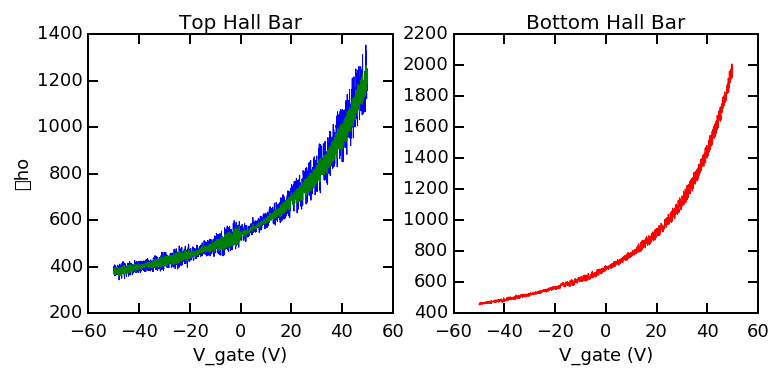

In [247]:
y5 = Waves('dat1534g5x.ibw').y
y6 = Waves('dat1534g6x.ibw').y
y8 = Waves('dat1534g8x.ibw').y
x = Waves('dat1534g8x.ibw').x
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, y5/1e-6/1.5, 'b')
ax[0].plot(x, y6/1e-6/1.5, 'g')
ax[1].plot(x, yb/1e-6/1.5, 'r')
ax[0].set_title('Top Hall Bar')
ax[1].set_title('Bottom Hall Bar')
ax[0].set_ylabel('\rho')
ax[0].set_xlabel('V_gate (V)')
ax[1].set_xlabel('V_gate (V)')

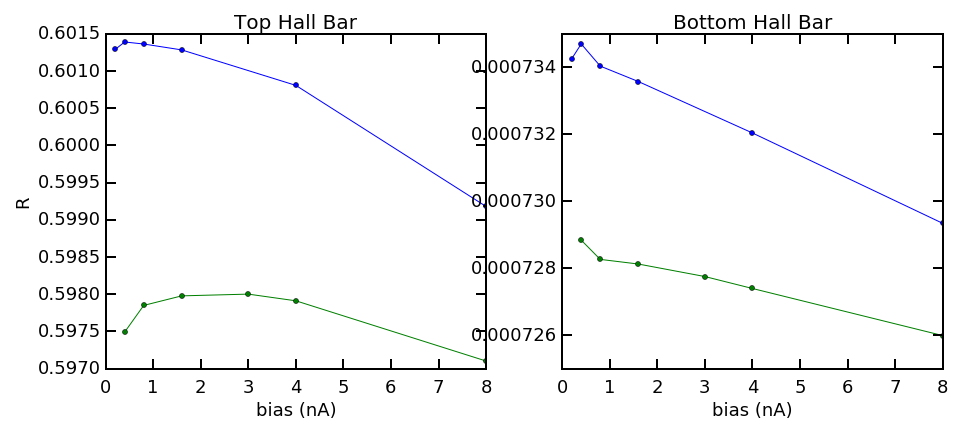

In [275]:
datnums = [n for n in range(1536, 1541+1)]
bias = [0.2, 0.4, 0.8, 1.6, 4.0, 8.0] 

d = {'B_parallel':-45.54, 'I_bias':bias, 'V_gate':-40.0, 'Tmix':17.8, 
      'sweep_type':'1d', 'sweeps':1}
df = create_metadata_frame(datnums, **d)
df['R_top'] = 0.0
df['R_btm'] = 0.0

for ind, row in df.iterrows():
    g6 = Waves('dat{0}g6x.ibw'.format(row['datnum'])).y
    g5 = Waves('dat{0}g5x.ibw'.format(row['datnum'])).y
    g8 = Waves('dat{0}g8x.ibw'.format(row['datnum'])).y
    g9 = Waves('dat{0}g9x.ibw'.format(row['datnum'])).y
    gtime = Waves('dat{0}g6x.ibw'.format(row['datnum'])).y
    df.loc[ind, 'R_top'] = g6.mean()/g9.mean()
    df.loc[ind, 'R_btm'] = g8.mean()/row['I_bias']
    
fig, ax = plt.subplots(1,2, figsize = (15,6))

ax[0].plot(bias, df['R_top'], marker='o')
ax[1].plot(bias, df['R_btm'], marker='o')
ax[0].set_title('Top Hall Bar')
ax[1].set_title('Bottom Hall Bar')
ax[0].set_ylabel('R')
ax[1].set_xlabel('bias (nA)')
ax[0].set_xlabel('bias (nA)')

datnums = [n for n in range(1568, 1573+1)]
bias = [0.4, 0.8, 1.6, 3.0, 4.0, 8.0] 
# R_top = [601.3, 601.4, 601.4, 601.3, 600.8, 599.2]
# R_btm = [734.3, 734.7, 734.0, 733.6, 732.0, 729.3]

d = {'B_parallel':-45.54, 'I_bias':bias, 'V_gate':-40.0, 'Tmix':50.0, 
      'sweep_type':'1d', 'sweeps':1}
df = create_metadata_frame(datnums, **d)
df['R_top'] = 0.0
df['R_btm'] = 0.0

for ind, row in df.iterrows():
    g6 = Waves('dat{0}g6x.ibw'.format(row['datnum'])).y
    g5 = Waves('dat{0}g5x.ibw'.format(row['datnum'])).y
    g8 = Waves('dat{0}g8x.ibw'.format(row['datnum'])).y
    g9 = Waves('dat{0}g9x.ibw'.format(row['datnum'])).y
    gtime = Waves('dat{0}g6x.ibw'.format(row['datnum'])).y
    df.loc[ind, 'R_top'] = g6.mean()/g9.mean()
    df.loc[ind, 'R_btm'] = g8.mean()/row['I_bias']
    
ax[0].plot(bias, df['R_top'], marker='o')
ax[1].plot(bias, df['R_btm'], marker='o')

In [274]:
df

datnum    sweeps sweep_type       Tmix     V_gate  B_parallel  \
0      1536.000000  1.000000         1d  17.799999 -40.000000  -45.540001   
1      1537.000000  1.000000         1d  17.799999 -40.000000  -45.540001   
2      1538.000000  1.000000         1d  17.799999 -40.000000  -45.540001   
3      1539.000000  1.000000         1d  17.799999 -40.000000  -45.540001   
4      1540.000000  1.000000         1d  17.799999 -40.000000  -45.540001   
5      1541.000000  1.000000         1d  17.799999 -40.000000  -45.540001   
R_top     0.599179  0.599179   0.599179   0.599179   0.599179    0.599179   

         I_bias     R_top     R_btm  
0      0.200000  0.000000  0.000734  
1      0.400000  0.000000  0.000735  
2      0.800000  0.000000  0.000734  
3      1.600000  0.000000  0.000734  
4      4.000000  0.000000  0.000732  
5      8.000000  0.000000  0.000729  
R_top  0.599179  0.599179  0.599179

-0.668225 0.259472


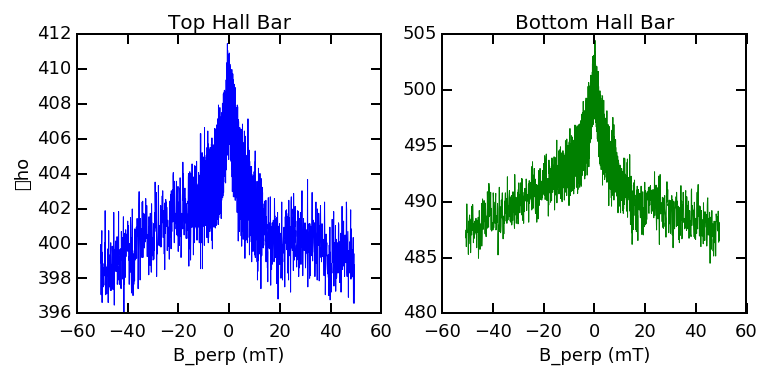

In [249]:
yt = Waves('dat1548g6x.ibw').y
yb = Waves('dat1548g8x.ibw').y
x = Waves('dat1548fields.ibw').y
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, yt/1.6e-6/1.5, 'b')
ax[1].plot(x, yb/1.6e-6/1.5, 'g')
ax[0].set_title('Top Hall Bar')
ax[1].set_title('Bottom Hall Bar')
ax[0].set_ylabel('\rho')
ax[0].set_xlabel('B_perp (mT)')
ax[1].set_xlabel('B_perp (mT)')

print x[yt.argmax()], x[yb.argmax()]

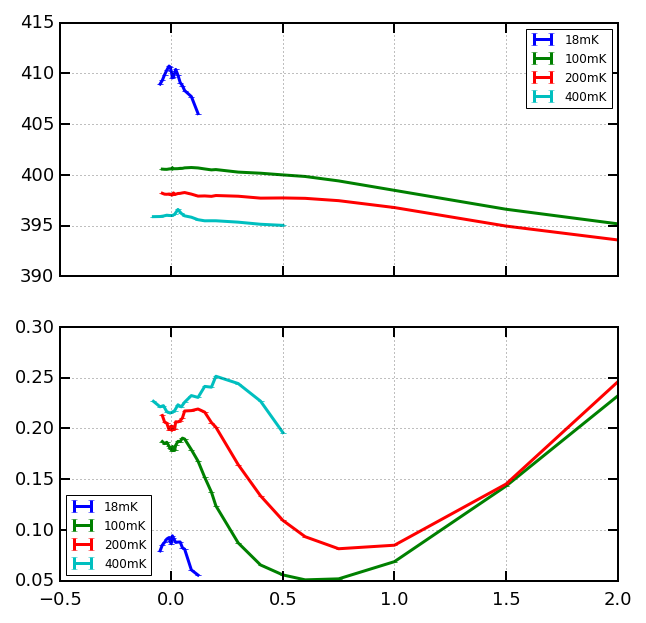

In [1220]:
# fit and plot V_gate = -40V data at different temperatures

# import data
df18 = pd.DataFrame.from_csv('analysis/bpar_18mK_n40V_1p6nA.csv')
df100 = pd.DataFrame.from_csv('analysis/bpar_100mK_n40V_8nA.csv')
df200 = pd.DataFrame.from_csv('analysis/bpar_200mK_n40V_10nA.csv')
df400 = pd.DataFrame.from_csv('analysis/bpar_400mK_n40V_15nA.csv')

# fits
fix = {'A': 1.08, 'Bi': 1.75, 'Bstar': 2500000.0, 'lin': 0.0027}

simultaneous_wlfits(df18, fix=fix, sample = 'top')
df18['Bphi'] = df18['Bphi0']
df18['ro'] = df18['ro0']
simultaneous_wlfits(df100, fix=fix, sample = 'top')
df100['Bphi'] = df100['Bphi0']
df100['ro'] = df100['ro0']
simultaneous_wlfits(df200, fix=fix, sample = 'top')
df200['Bphi'] = df200['Bphi0']
df200['ro'] = df200['ro0']
simultaneous_wlfits(df400, fix=fix, sample = 'top')
df400['ro'] = df400['ro0']
df400['Bphi'] = df400['Bphi0']

df18.to_csv('analysis/bpar_18mK_n40V_1p6nA.csv')
df100.to_csv('analysis/bpar_100mK_n40V_8nA.csv')
df200.to_csv('analysis/bpar_200mK_n40V_10nA.csv')
df400.to_csv('analysis/bpar_400mK_n40V_15nA.csv')

fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)

ax[0].errorbar(df18['B_parallel'], df18['ro'].values, yerr = df18['ro_stderr'], lw = 3, label = '18mK')
ax[1].errorbar(df18['B_parallel'], df18['Bphi'].values, yerr = df18['Bphi_stderr'], lw = 3, label = '18mK')

ax[0].errorbar(df100['B_parallel'], df100['ro'].values, yerr = df100['ro_stderr'], lw = 3, label = '100mK')
ax[1].errorbar(df100['B_parallel'], df100['Bphi'].values, yerr = df100['Bphi_stderr'], lw = 3, label = '100mK')

ax[0].errorbar(df200['B_parallel'], df200['ro'].values, yerr = df200['ro_stderr'], lw = 3, label = '200mK')
ax[1].errorbar(df200['B_parallel'], df200['Bphi'].values, yerr = df200['Bphi_stderr'], lw = 3, label = '200mK')

ax[0].errorbar(df400['B_parallel'], df400['ro'].values, yerr = df400['ro_stderr'], lw = 3, label = '400mK')
ax[1].errorbar(df400['B_parallel'], df400['Bphi'].values, yerr = df400['Bphi_stderr'], lw = 3, label = '400mK')

ax[0].grid()
ax[1].grid()

# ax[1].set_xlim(-0.1, 0.1)
# ax[1].set_ylim(0.17, 0.27)
ax[0].legend()
ax[1].legend(loc='lower left')

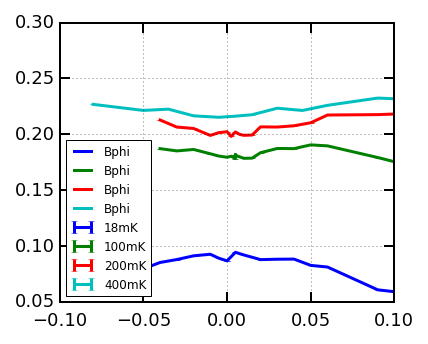

In [1221]:
fig, ax = plt.subplots(1,1)

ax.errorbar(df18['B_parallel'], df18['Bphi'], yerr = df18['Bphi_stderr'], lw = 3, label = '18mK')

# ax[0].errorbar(df100['B_parallel'], df100['ro'], yerr = df100['ro_stderr'], lw = 3, label = '100mK')
ax.errorbar(df100['B_parallel'], df100['Bphi'], yerr = df100['Bphi_stderr'], lw = 3, label = '100mK')

# ax[0].errorbar(df200['B_parallel'], df200['ro'], yerr = df200['ro_stderr'], lw = 3, label = '200mK')
ax.errorbar(df200['B_parallel'], df200['Bphi'], yerr = df200['Bphi_stderr'], lw = 3, label = '200mK')

# ax[0].errorbar(df400['B_parallel'], df400['ro'], yerr = df400['ro_stderr'], lw = 3, label = '400mK')
ax.errorbar(df400['B_parallel'], df400['Bphi'], yerr = df400['Bphi_stderr'], lw = 3, label = '400mK')

ax.grid()

ax.set_xlim(-0.1, 0.1)
# ax.set_ylim(0.17, 0.27)
ax.legend()
ax.legend(loc='lower left')

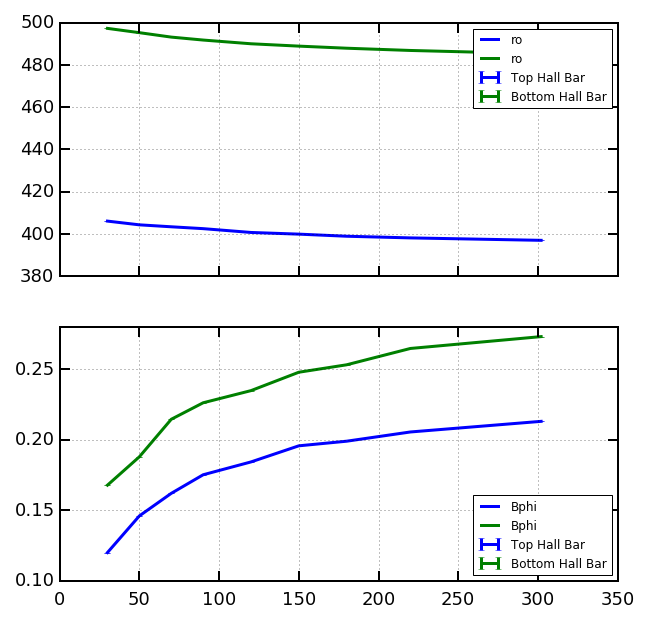

In [1224]:
# looking at B_phi as a function of temperature at B_parallel = 5mT

# top sample
df = pd.DataFrame.from_csv('analysis/temp_varyI_5mT_n40V.csv') # load data

fix = {'A': 1.08, 'Bi': 1.75, 'Bstar': 2500000.0, 'lin': 0.0027}
simultaneous_wlfits(df, fix=fix, sample='top')
df['Bphi'] = df['Bphi0']
df['ro'] = df['ro0']
df.to_csv('analysis/temp_varyI_5mT_n40V_topfits.csv')

fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)

ax[0].errorbar(df['Tmix'], df['ro'], yerr = df['ro_stderr'], lw = 3, label = 'Top Hall Bar')
ax[1].errorbar(df['Tmix'], df['Bphi'], yerr = df['Bphi_stderr'], lw = 3, label = 'Top Hall Bar')

# bottom sample
del df
df = pd.DataFrame.from_csv('analysis/temp_varyI_5mT_n40V.csv') # load data

fix = {'A': 1.08, 'Bi': 1.75, 'Bstar': 2500000.0, 'lin': 0.0027}
simultaneous_wlfits(df, fix=fix, sample='bottom')
df['Bphi'] = df['Bphi0']
df['ro'] = df['ro0']
df.to_csv('analysis/temp_varyI_5mT_n40V_btmfits.csv')

ax[0].errorbar(df['Tmix'], df['ro'], yerr = df['ro_stderr'], lw = 3, label = 'Bottom Hall Bar')
ax[1].errorbar(df['Tmix'], df['Bphi'], yerr = df['Bphi_stderr'], lw = 3, label = 'Bottom Hall Bar')

ax[0].grid()
ax[1].grid()

ax[0].legend()
ax[1].legend(loc='lower right')

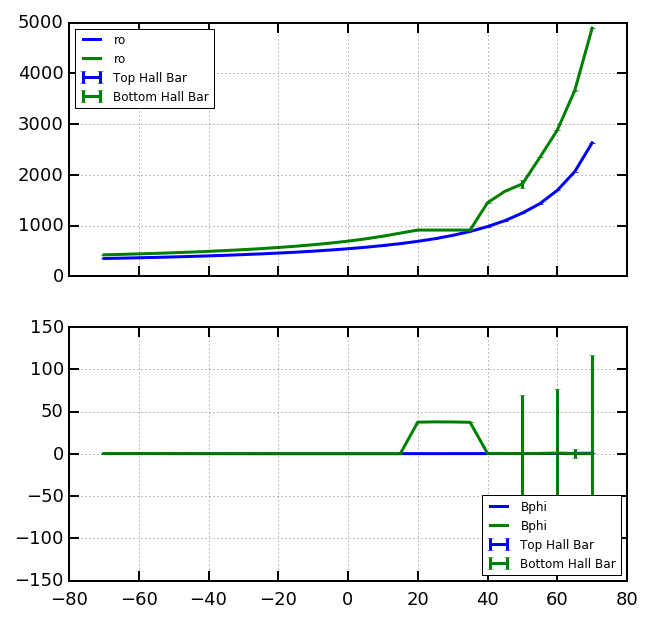

In [901]:
# looking at B_phi as a function of gate at 100mK and B_parallel = 5mT

# top sample
del df
df = pd.DataFrame.from_csv('analysis/gate_5mT_100mK_8nA.csv') # load data

fix = {'A': 1.08, 'Bi': 1.75, 'Bstar': 2500000.0, 'lin': 0.0027}
get_single_wlfits(df, 0.8, 3, fix=fix, sample='top')
get_average_wlfits(df, 0.8, 3, fix=fix, sample='top')
df.to_csv('analysis/gate_5mT_100mK_8nA_topfits.csv')

fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)

ax[0].errorbar(df['V_gate'], df['ro'], yerr = df['ro_stderr'], lw = 3, label = 'Top Hall Bar')
ax[1].errorbar(df['V_gate'], df['Bphi'], yerr = df['Bphi_stderr'], lw = 3, label = 'Top Hall Bar')

# bottom sample
del df
df = pd.DataFrame.from_csv('analysis/gate_5mT_100mK_8nA.csv') # load data
# drop_gates = [15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 60, 65, 70.0]
# df = df[~df['V_gate'].isin(drop_gates)]

fix = {'A': 1.08, 'Bi': 1.75, 'Bstar': 2500000.0, 'lin': 0.0027}
get_single_wlfits(df, 0.8, 3, fix=fix, sample='bottom')
get_average_wlfits(df, 0.8, 3, fix=fix, sample='bottom')
df.to_csv('analysis/gate_5mT_100mK_8nA_btmfits.csv')

ax[0].errorbar(df['V_gate'], df['ro'], yerr = df['ro_stderr'], lw = 3, label = 'Bottom Hall Bar')
ax[1].errorbar(df['V_gate'], df['Bphi'], yerr = df['Bphi_stderr'], lw = 3, label = 'Bottom Hall Bar')

ax[0].grid()
ax[1].grid()

ax[0].legend(loc='upper left')
ax[1].legend(loc='lower right')

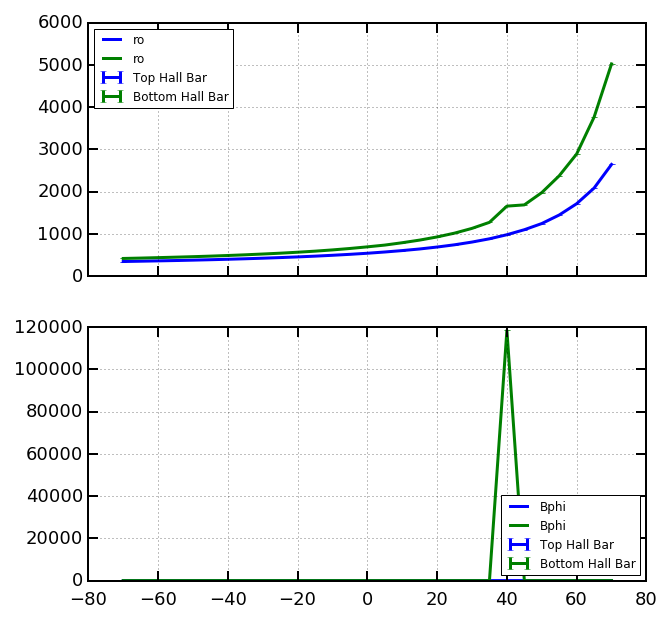

In [903]:
# looking at B_phi as a function of gate at 100mK and B_parallel = 500mT

# top sample
del df
df = pd.DataFrame.from_csv('analysis/gate_500mT_100mK_8nA.csv') # load data

fix = {'A': 1.08, 'Bi': 1.75, 'Bstar': 2500000.0, 'lin': 0.0027}
get_single_wlfits(df, 0.8, 3, fix=fix, sample='top')
get_average_wlfits(df, 0.8, 3, fix=fix, sample='top')
df.to_csv('analysis/gate_500mT_100mK_8nA_topfits.csv')

fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)

ax[0].errorbar(df['V_gate'], df['ro'], yerr = df['ro_stderr'], lw = 3, label = 'Top Hall Bar')
ax[1].errorbar(df['V_gate'], df['Bphi'], yerr = df['Bphi_stderr'], lw = 3, label = 'Top Hall Bar')

# bottom sample
del df
df = pd.DataFrame.from_csv('analysis/gate_500mT_100mK_8nA.csv') # load data
# drop_gates = [15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 60, 65, 70.0]
# df = df[~df['V_gate'].isin(drop_gates)]

fix = {'A': 1.08, 'Bi': 1.75, 'Bstar': 2500000.0, 'lin': 0.0027}
get_single_wlfits(df, 0.8, 3, fix=fix, sample='bottom')
get_average_wlfits(df, 0.8, 3, fix=fix, sample='bottom')
df.to_csv('analysis/gate_500mT_100mK_8nA_btmfits.csv')

ax[0].errorbar(df['V_gate'], df['ro'], yerr = df['ro_stderr'], lw = 3, label = 'Bottom Hall Bar')
ax[1].errorbar(df['V_gate'], df['Bphi'], yerr = df['Bphi_stderr'], lw = 3, label = 'Bottom Hall Bar')

ax[0].grid()
ax[1].grid()

ax[0].legend(loc='upper left')
ax[1].legend(loc='lower right')

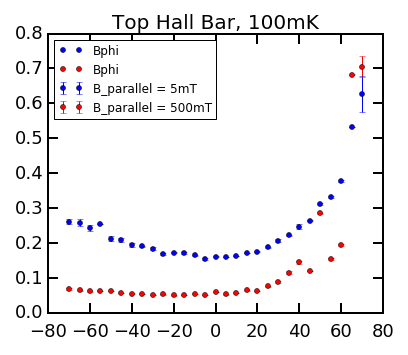

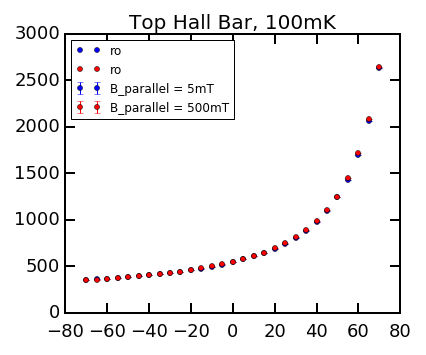

In [904]:
# compare Bphi vs V_gate data at B_parallel = 5mT and 500mT

df5 = pd.DataFrame.from_csv('analysis/gate_5mT_100mK_8nA_topfits.csv')
df500 = pd.DataFrame.from_csv('analysis/gate_500mT_100mK_8nA_topfits.csv')

fig, ax = plt.subplots(1,1)

ax.errorbar(df5['V_gate'], df5['Bphi'], yerr=df5['Bphi_stderr'], fmt='bo', label = 'B_parallel = 5mT')
ax.errorbar(df500['V_gate'], df500['Bphi'], yerr=df500['Bphi_stderr'], fmt = 'ro', label = 'B_parallel = 500mT')
ax.legend(loc = 'upper left')
ax.set_title('Top Hall Bar, 100mK')

fig, ax = plt.subplots(1,1)

ax.errorbar(df5['V_gate'], df5['ro'], yerr=df5['ro_stderr'], fmt='bo', label = 'B_parallel = 5mT')
ax.errorbar(df500['V_gate'], df500['ro'], yerr=df500['ro_stderr'], fmt = 'ro', label = 'B_parallel = 500mT')
ax.legend(loc = 'upper left')
ax.set_title('Top Hall Bar, 100mK')

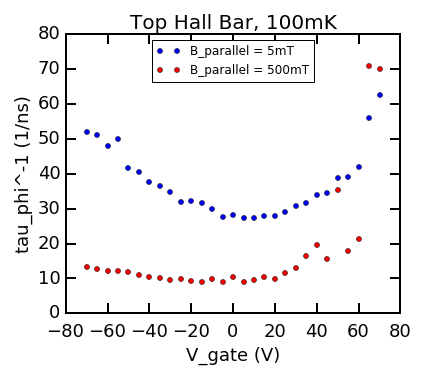

In [911]:
# now try to plot the dephasing rate, tau_phi, 
# as a function of V_gate B_parallel = 5mT and 500mT

vf = 1e6 #m/s
hbar = 1.0545718e-34 # m^2kg/s
e = 1.60217662e-19 # coulombs

def density(V_gate):
    """ charge density as a function of gate voltage as calculated in
        dat1710, 1714, 1716-1720 """
    return -6.7e14*V_gate + 5.4e16 #1/m^2

def diffusion(r_0, V_gate):
    """ diffusion constant as calculated from the conductance at a given V_gate """
    return (1/r_0)*(np.pi*hbar*vf)/(np.sqrt(density(V_gate)*np.pi))/(2*e*e)

def tauphi(D, B_phi):
    """ return the dephasing rate in nanoseconds. assumes B_phi in mT"""
    return(hbar/(4*e))*np.power((D*B_phi*(1e-3)), -1)*1e9

df5 = pd.DataFrame.from_csv('analysis/gate_5mT_100mK_8nA_topfits.csv')
df500 = pd.DataFrame.from_csv('analysis/gate_500mT_100mK_8nA_topfits.csv')

df5['ns'] = density(df5['V_gate'])
df500['ns'] = density(df500['V_gate'])
df5['D'] = diffusion(df5['ro'], df5['V_gate'])
df500['D'] = diffusion(df500['ro'], df500['V_gate'])
df5['tauphi'] = tauphi(df5['D'], df5['Bphi'])
df500['tauphi'] = tauphi(df500['D'], df500['Bphi'])

fig, ax = plt.subplots(1,1)

ax.errorbar(df5['V_gate'], (df5['tauphi'].values)**-1, 
             fmt = 'bo', label = 'B_parallel = 5mT')
ax.errorbar(df500['V_gate'], (df500['tauphi'].values)**-1, 
             fmt = 'ro', label = 'B_parallel = 500mT')

ax.legend(loc = 'upper center')
ax.set_title('Top Hall Bar, 100mK')
ax.set_xlabel('V_gate (V)')
ax.set_ylabel('tau_phi^-1 (1/ns)')

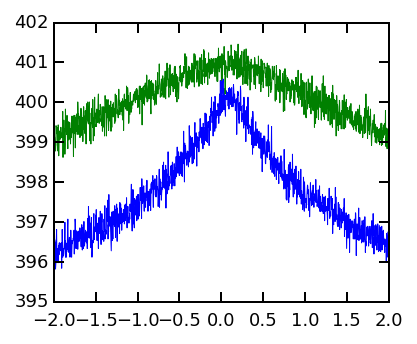

In [928]:
def get_center():
if not bcenter:
        bcenter = b.mean()
    if not ro:
        ro = rxx[find_nearest(b, bcenter)]

def select_data(a, b):
    width = 0.8
    height = 3.0
    
    center
    ro
    
    right = center+width
    left = center-width 
    top = ro+height
    bottom = ro-height  

    bi = (b > left) & (b < right)
    ri = (rxx > bottom)
    inds = bi & ri

    b = b[inds]
    rxx = rxx[inds]

    return a, b

df = pd.DataFrame.from_csv('analysis/bpar_100mK_n40V_8nA.csv')



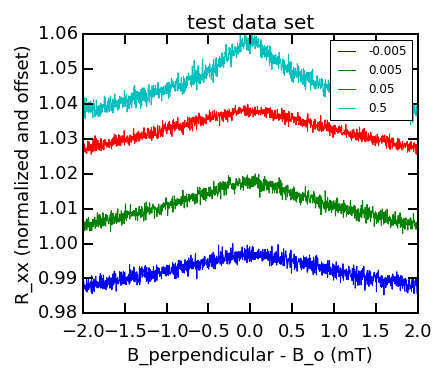

In [1080]:
### create test data set ###

# files = ['test_n5', 'test_5', 'test_50', 'test_500']
bparallel = np.array([-0.005, 0.005, 0.05, 0.5])
centers = bparallel*30.9 - 1.7
ros = np.array([550.0, 610.0, 710.0, 490.0])
bphis = np.array([0.2, 0.16, 0.225, 0.05])

testf = pd.DataFrame(np.column_stack((files, bparallel, centers, ros, bphis)), 
                     columns = ['file_name', 'B_parallel', 'bo', 'ro', 'Bphi'])
testf['A'] = 1.8
testf['Bi'] = 1.75
testf['Bstar'] = 2500000.0
testf['lin'] = 0.0027
testf.iloc[:,1:] = testf.iloc[:,1:].astype(np.float)
testf.to_csv('analysis/test_metadata.csv')

fig, ax = plt.subplots(1,1)

for ind in testf.index:
    row = testf.loc[ind,:]
    bperp = np.linspace(row['bo']-2.0, row['bo']+2.0, 1250)
    rxx = wlcorr(bperp, row['bo'], row['ro'], row['Bphi'], row['Bi'], row['Bstar'], row['lin'], row['A'])
    rxx += np.random.normal(0.0, 0.7, *rxx.shape)
    np.savetxt('analysis/'+row['file_name']+'_fields.test', bperp, delimiter=",")
    np.savetxt('analysis/'+row['file_name']+'_rxx.test', rxx, delimiter=",")
    ax.plot(bperp-row['bo'], rxx/rxx.max()+0.02*ind, label = testf.loc[ind, 'B_parallel'])
ax.legend()
ax.set_xlabel('B_perpendicular - B_o (mT)')
ax.set_ylabel('R_xx (normalized and offset)')
ax.set_title('test data set')

In [1081]:
testf = pd.DataFrame.from_csv('analysis/test_metadata.csv')

datnums = [0, 0, 0, 0]
bparallel = np.array([-0.005, 0.005, 0.05, 0.5])
mdata = {'sweeps':1, 'sweep_type':'test', 'Tmix':100.0, 'V_gate':0.0, 'B_parallel':bparallel, 'I_bias':1.0}
df = create_metadata_frame(datnums, **mdata)
add_wlfit_columns(df)
df.sort(columns='B_parallel', axis=0, ascending=True, inplace=True)

fix = {'A':1.8, 'Bi':1.75, 'Bstar':2500000.0, 'lin':0.0027}

width = 10.0
height = 1.00

for ind in df.index:
    filename = testf.loc[ind, 'file_name']

    fields = np.loadtxt('analysis/'+filename+'_fields.test')
    rxx = np.loadtxt('analysis/'+filename+'_rxx.test')

    result = wl_fit(fields, rxx, width, height, fix = fix, ro=None, bcenter = None)
    for p in result.params:
        df.loc[ind,p] = result.values[p]

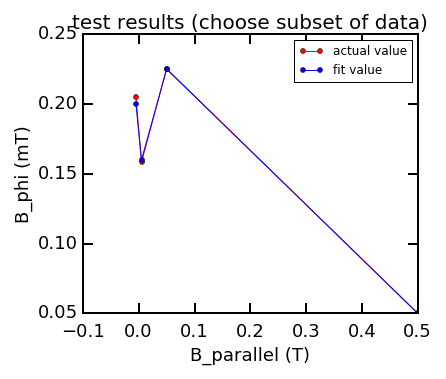

In [1082]:
fig, ax = plt.subplots(1,1)
ax.plot(df['B_parallel'], df['Bphi'], 'r', marker = 'o', label = 'actual value')
ax.plot(testf['B_parallel'], testf['Bphi'], 'b', marker = 'o', label = 'fit value')
ax.set_xlabel('B_parallel (T)')
ax.set_ylabel('B_phi (mT)')
ax.set_title('test results (choose subset of data)')
ax.legend()

In [1215]:
df = pd.DataFrame.from_csv('analysis/bpar_100mK_n40V_8nA.csv')
drop = [1582, 1583]
df = df[~df['datnum'].isin(drop)]

fix = {'A': 1.08, 'Bi': 1.75, 'Bstar': 2500000.0, 'lin': 0.0027}
simultaneous_wlfits(df, fix, sample = 'top')

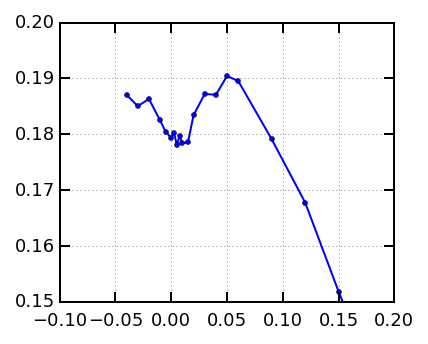

In [1216]:
plt.plot(df['B_parallel'], df['Bphi0'], marker = 'o', linewidth = 2)
plt.xlim(-0.1, 0.2)
plt.ylim(0.15, 0.20)
plt.grid()